In [1]:
from utils import *
from ISM import *

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font) 
text = {'usetex': False}
matplotlib.rc('text', **text)
monospace_font = {'fontname':'monospace'}


# Get the data ready:
0. initial filtering to remove short reads
1. sequences are aligned using MAFFT with FFT-NS-2 method
2. gisaid_epi_isl number are used to merge medadata from [Nextstrain](https://raw.githubusercontent.com/nextstrain/ncov/master/data/metadata.tsv)
3. filter out sequences from non-human hosts

In [2]:
GISAID_DATA_DATE = '20200419'
print('This report covers GISAID data downloaded in: {}'.format(GISAID_DATA_DATE))

This report covers GISAID data downloaded in: 20200419


In [3]:
gisaid_filename = 'gisaid_cov2020_sequences_{}.fasta'.format(GISAID_DATA_DATE)
MIN_LEN = 25000
seq_list = read_fasta(gisaid_filename)

seq_dict = {}
for header, seq in seq_list:
    header = header.replace(' ', '')
    if len(seq) < MIN_LEN:
        continue
    if header in seq_dict:
        print('ignoring duplicated submissions: {}'.format(header))
        continue
    seq_dict[header] = seq
reference_filename = 'data/covid-19-reference.fasta'
reference = read_fasta(reference_filename)
seq_dict['SARS coronavirus 2 (NC045512.2)|NC_045512.2|2020-03-30'] = reference[0][1]


filtered_filename = 'gisaid_cov2020_sequences_{}_filtered.fasta'.format(GISAID_DATA_DATE)
write_fasta(filtered_filename, seq_dict)

In [4]:
# !grep '>' gisaid_cov2020_sequences_20200419_filtered.fasta | wc -l

In [5]:
# MAFFT alignment is done in XSEDE
# download metadata from Nextstrain
# !wget -O data/metadata_20200421.tsv https://raw.githubusercontent.com/nextstrain/ncov/master/data/metadata.tsv

In [6]:
seq_df, REFERENCE = load_data(gisaid_filename = 'mafft_{}.output'.format(GISAID_DATA_DATE))
meta_df = pd.read_csv('data/metadata_20200421.tsv', sep='\t')
data_df = preprocessing(seq_df, meta_df)
print('Total numer of sequences in the end: {}'.format(data_df.shape[0]))

Total numer of sequences in the end: 10348


# Entropy analysis for Informative Subtype Marker picking:
1. do entropy analysis with the reference sequence.
2. pick up high entropy spots and filter out invalid spots
3. pick up ISMs then map them back to the reference for annotation purposes.

In [7]:
output_folder = 'results_20200419'

In [8]:
# unqiue characters:
seq_list = data_df['sequence'].values.tolist()
seq_list.append(REFERENCE[1])

In [9]:
base_set = set([])
for seq in seq_list:
    base_set.update(set(seq))
H_list = []
null_freq_list = []
for i in range(len(seq_list[0])):
    H, null_freq = base_entropy_masked(seq_list, base_set, i)
    H_list.append(H,)
    null_freq_list.append(null_freq)

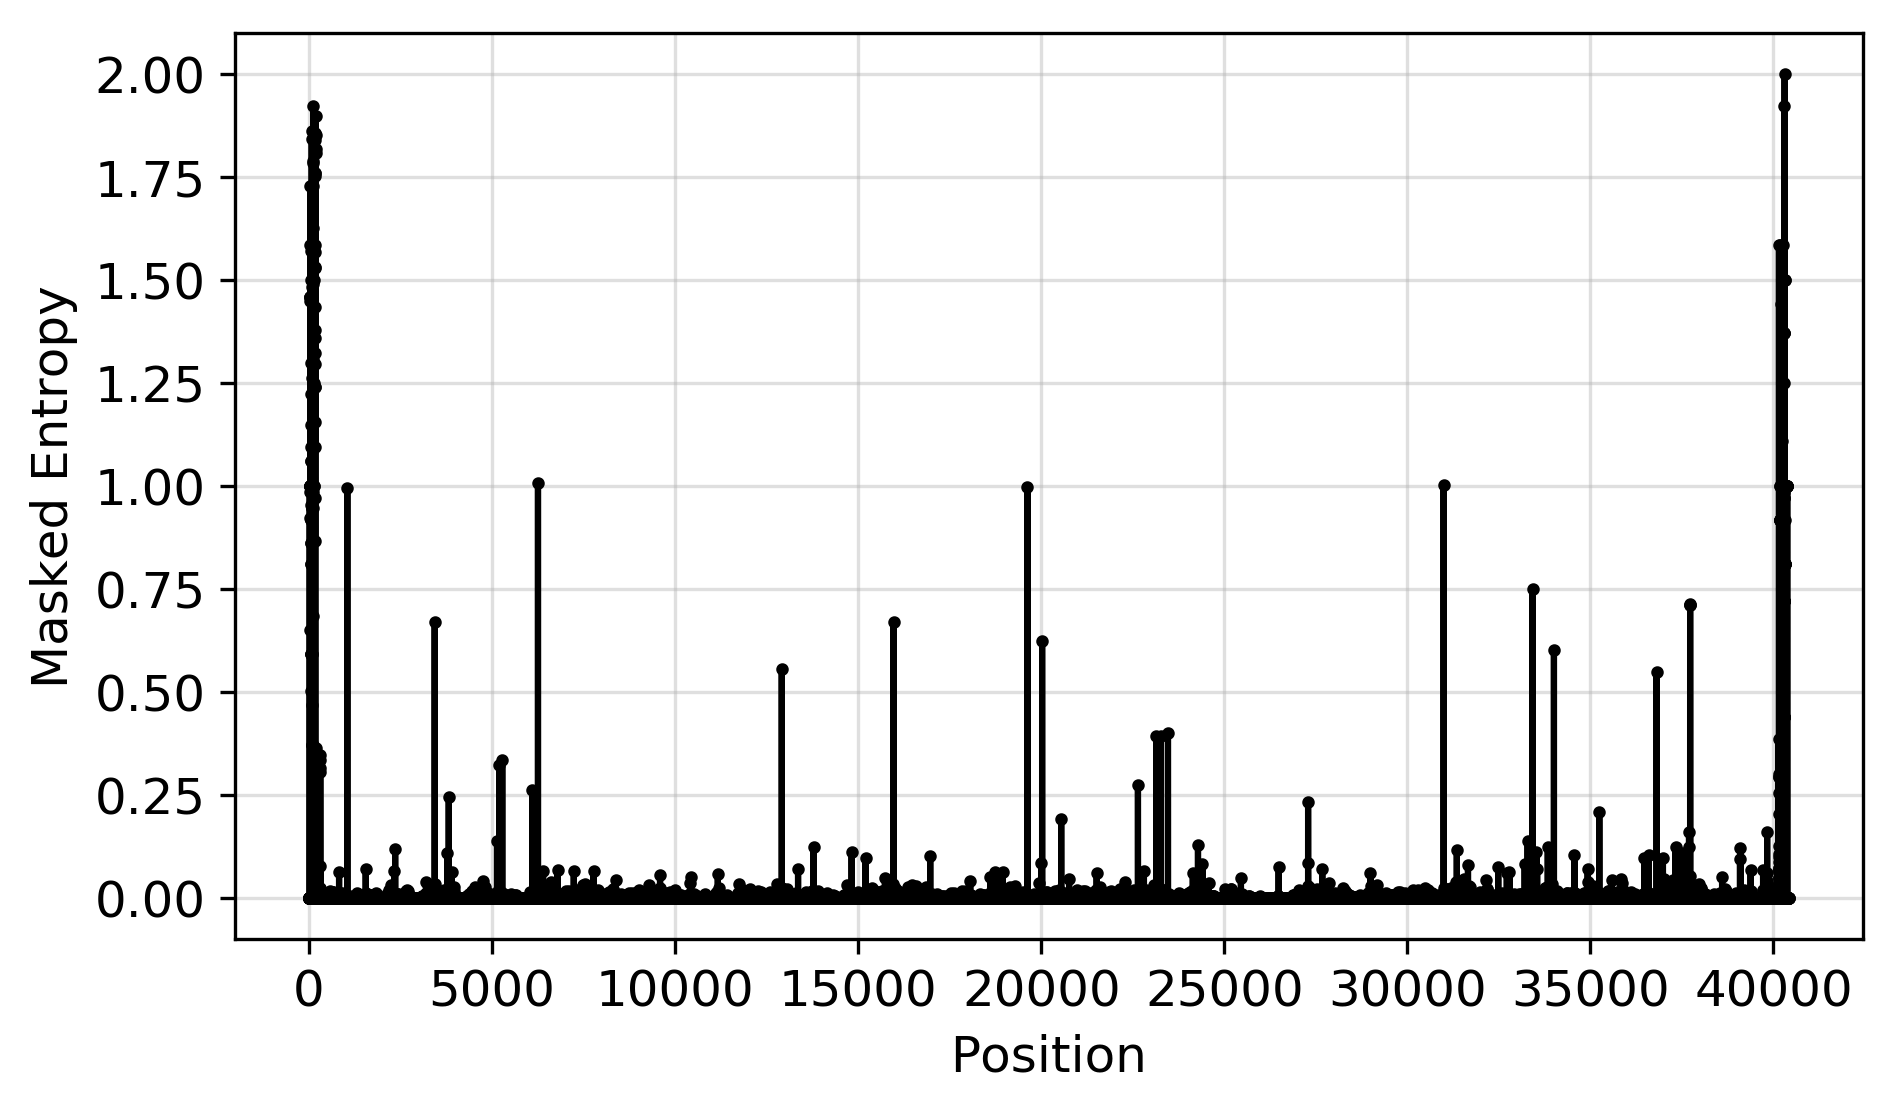

In [10]:
DPI = 300

fig = plt.figure(figsize=(2100/DPI, 1200/DPI), dpi=DPI)   
# plt.plot(H_list)
plt.plot(np.arange(len(H_list)), np.array(H_list), 'ko-', markersize = 2)
plt.grid(alpha = 0.4)
plt.xlabel('Position')
plt.ylabel('Masked Entropy')
plt.savefig('{}/1_overall_entropy.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

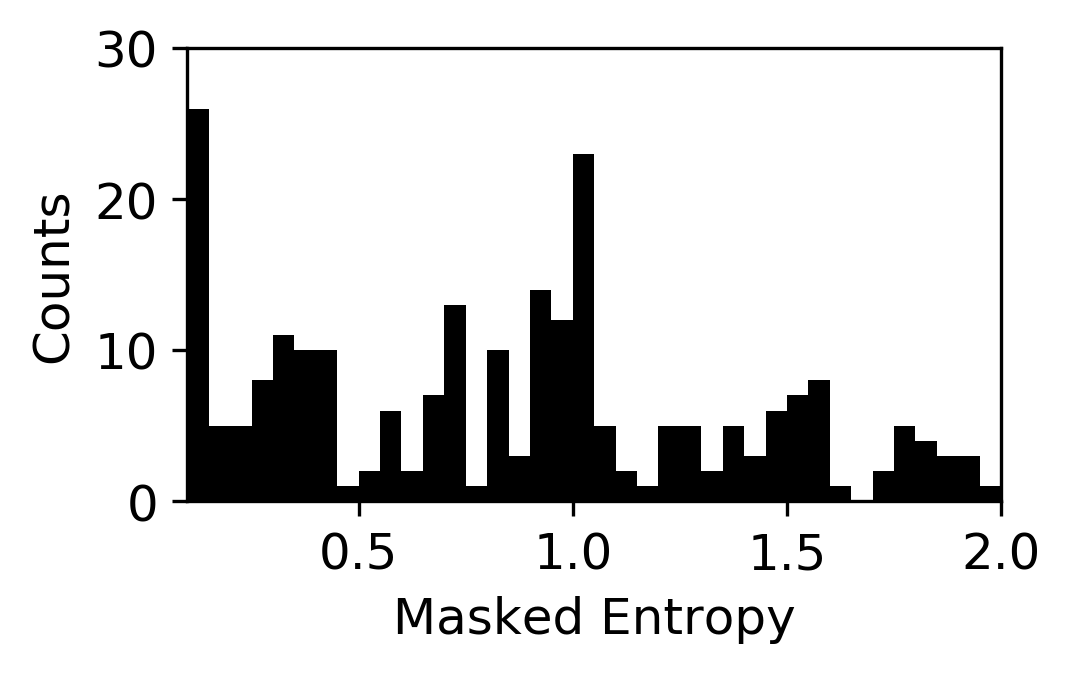

In [11]:
fig = plt.figure(figsize=(1050/DPI, 600/DPI), dpi=DPI)   
n, bins, patches = plt.hist(H_list, 40, color = 'black')
plt.xlim([0.1, 2])
plt.ylim([0, 30])
plt.xlabel('Masked Entropy')
plt.ylabel('Counts')
plt.savefig('{}/2_masked_entropy_histogram.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

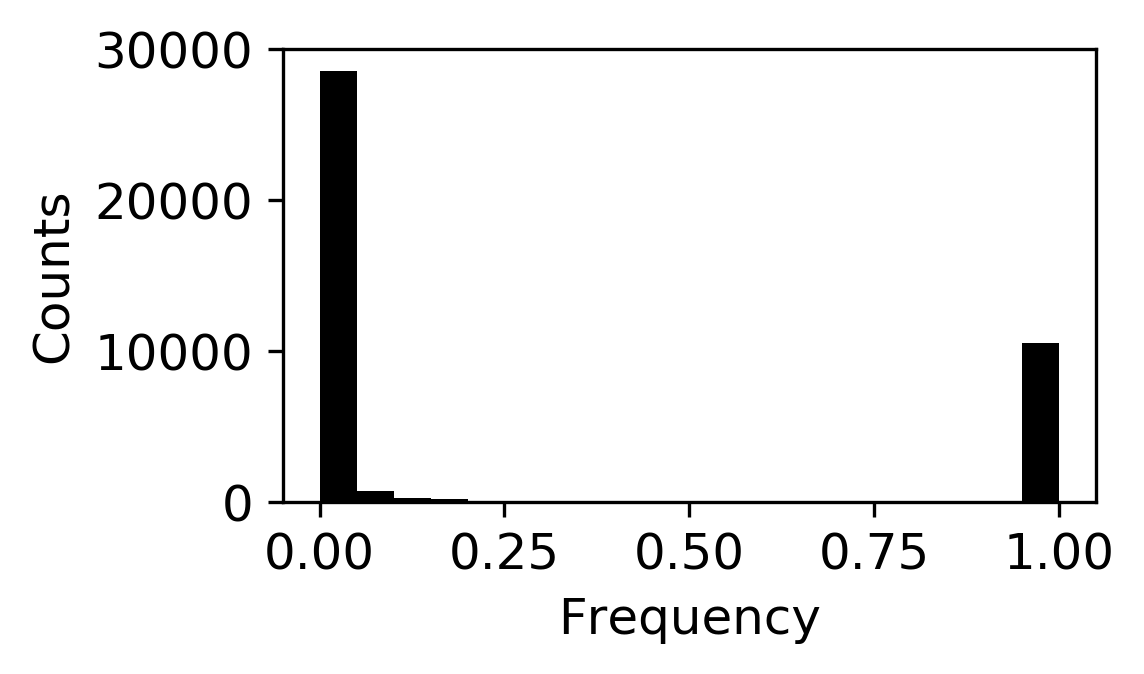

In [12]:
fig = plt.figure(figsize=(1050/DPI, 600/DPI), dpi=DPI)   
n, bins, patches = plt.hist(null_freq_list, 20, color = 'black')
# plt.xlim([0.1, 0.9])
# plt.ylim([0, 40])
plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.savefig('{}/3_null_frequency_histogram.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

In [13]:
# figure out good region:
# using Entropy threshold 0.35 to pick up the US subtype ISM
import numpy as np
tmp = np.where(np.array(H_list) > 0.35)[0]
position_list = []
pairs = []
for base_idx in tmp.tolist():
    null_freq = null_freq_list[base_idx]
    if null_freq < 0.25:
#         print(base_idx, null_freq, H_list[base_idx])
        position_list.append(base_idx)
        pairs.append((base_idx, H_list[base_idx]))
len(pairs)

17

In [14]:
seq_index = []
index = 0
for base in REFERENCE[1]:
    if base == '-':
        seq_index.append(index)
    else:
        index += 1
        seq_index.append(index)
reference_local_index_map = np.array(seq_index)
mapped_reference_index = []
for index, entropy in pairs:
     mapped_reference_index.append((reference_local_index_map[index], entropy))

In [15]:
REFERENCE_ISM = ''.join([REFERENCE[1][idx] for idx in position_list])
print('Reference ISM: {}'.format(REFERENCE_ISM))

Reference ISM: CCCCGCCCACAGGTGGG


In [16]:
def annotate_ISM_positions(mapped_reference_index, reference_genbank_name="data/covid-19-genbank.gb", output_dir='figures'):
    recs = [rec for rec in SeqIO.parse(reference_genbank_name, "genbank")]

    gene_dict = {}
    for rec in recs:
        feats = [feat for feat in rec.features if feat.type == "CDS"]
        for feat in feats:
            key = (feat.location.start.position, feat.location.end.position)
            content = '{}: {}'.format(feat.qualifiers['protein_id'][0], feat.qualifiers['product'][0])
            gene_dict[key] = content

    with open('{}/ISM_gene_in_reference.csv'.format(output_dir), 'w+') as fw:
        output = '{:^10} | {:^6} | {:^70}'.format('Ref POS', 'Entropy', 'Gene')
        print(output)
        print('-'*10 + '   ' + '-'*7 + '   ' + '-'* 70)
        fw.write(output + '\n')
        for index, entropy in mapped_reference_index:
            result = []
            for key in gene_dict:
                if index >= key[0] and index <= key[1]:
                    result.append(gene_dict[key])
            output = '{:>10} | {:.5f} | {:<70}'.format(index, entropy, ', '.join(result))
            print(output + '\n')
            fw.write(output + '\n') 

In [17]:
annotate_ISM_positions(mapped_reference_index, reference_genbank_name="data/covid-19-genbank.gb", output_dir='results_20200419')

 Ref POS   | Entropy |                                  Gene                                 
----------   -------   ----------------------------------------------------------------------
       241 | 0.99471 |                                                                       

      1059 | 0.66911 | YP_009725295.1: ORF1a polyprotein, YP_009724389.1: ORF1ab polyprotein 

      3037 | 1.00816 | YP_009725295.1: ORF1a polyprotein, YP_009724389.1: ORF1ab polyprotein 

      8782 | 0.55553 | YP_009725295.1: ORF1a polyprotein, YP_009724389.1: ORF1ab polyprotein 

     11083 | 0.66909 | YP_009725295.1: ORF1a polyprotein, YP_009724389.1: ORF1ab polyprotein 

     14408 | 0.99891 | YP_009724389.1: ORF1ab polyprotein                                    

     14805 | 0.62330 | YP_009724389.1: ORF1ab polyprotein                                    

     17747 | 0.39392 | YP_009724389.1: ORF1ab polyprotein                                    

     17858 | 0.39413 | YP_009724389.1: ORF1ab polypr

In [18]:
data_df['ISM'] = data_df.apply(lambda x, position_list=position_list: ''.join([x['sequence'][idx] for idx in position_list]), axis=1)
ISM_df = data_df.drop(['sequence'], axis=1)

In [19]:
ISM_df.to_csv('{}/IMS_17nt_without_correction.csv'.format(output_folder), index=False)

In [20]:
print('Unique ISMs before correction: {}'.format(ISM_df['ISM'].unique().shape[0]))

Unique ISMs before correction: 382


## error correction

In [21]:
# https://www.bioinformatics.nl/molbi/SCLResources/sequence_notation.htm
ambiguous_base = {'B': set(['C', 'G', 'T']), 
                  'D': set(['A', 'G', 'T']),
                  'H': set(['A', 'C', 'T']),
                  'K': set(['G', 'T']),
                  'M': set(['A', 'C']),
                  'N': set(['A', 'C', 'G', 'T']),
                  'R': set(['A', 'G']),
                  'S': set(['C', 'G']),
                  'V': set(['A', 'C', 'G']),
                  'W': set(['A', 'T']),
                  'Y': set(['C', 'T'])}
base_to_ambiguous = {}
for base in ambiguous_base:
    bases = ''.join(sorted(ambiguous_base[base]))
    base_to_ambiguous[bases] = base
    
ISM_list = list(ISM_df['ISM'].values)
error_ISM_list = list(ISM_df[ISM_df.apply(lambda x, 
                          ambiguous_base=ambiguous_base: True if len(set(x['ISM']).intersection(ambiguous_base)) > 0 else False, 
                          axis = 1)]['ISM'].unique())
ERR_DICT = {}
for ISM in error_ISM_list:
    ERR_DICT[ISM] = ISM_df[ISM_df['ISM'] == ISM].shape[0]
ISM_LEN = len(ISM_list[0])
partial_ISM = 0
partial_subj = 0
full_ISM = 0
full_subj = 0
total_ISM = len(error_ISM_list)
total_subj = sum([ERR_DICT[item] for item in ERR_DICT])
ISM_error_correction_partial = {}
ISM_error_correction_full = {}

def check_completeness(ISM):
    for item in ISM:
        if item not in ['A', 'T', 'C', 'G', '-']:
            return False
    return True

for error in error_ISM_list:
    FLAG, correction = error_correction(error, ambiguous_base, base_to_ambiguous, ISM_list, ISM_LEN, THRESHOLD = 0)
    FLAG = check_completeness(correction)
    if error != correction:
        ISM_error_correction_partial[error] = correction
        partial_ISM += 1
        partial_subj += ERR_DICT[error]
    if FLAG and error != correction:
        ISM_error_correction_full[error] = correction
        full_ISM += 1
        full_subj += ERR_DICT[error]
print('% ISM partially corrected over ISMs with error:', partial_ISM/total_ISM)
print('% ISM completed corrected over ISMs with error:', full_ISM/total_ISM)
print('% Subject partially corrected over subjects with error:', partial_subj/total_subj)
print('% Subject partially corrected over subjects with error:', full_subj/total_subj)

LOG: new bases {'A', 'G'} conflict with or are not as good as original bases {'T', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} conflict with or are not as good as original bases {'A', 'G'}
LOG: new bases {'T', 'G'} confli

In [22]:
ISM_df['ISM'] = ISM_df.apply(lambda x, 
             error_correction=ISM_error_correction_partial: error_correction[x['ISM']] if x['ISM'] in error_correction else x['ISM'],
             axis = 1
            )

In [62]:
ISM_df.to_csv('{}/IMS_17nt_with_correction.csv'.format(output_folder), index=False)

In [63]:
ISM_df.shape

(10348, 20)

In [23]:
print('Unique ISMs after error correction: {}'.format(ISM_df['ISM'].unique().shape[0]))

Unique ISMs after error correction: 252


In [24]:
acknowledgement_table = ISM_df[['gisaid_epi_isl', 'date', 'segment', 'originating_lab', 'submitting_lab', 'authors', 'url', 'date_submitted']]
acknowledgement_table.to_csv('acknowledgement_table.csv', index = False)

In [25]:
ISM_index = {}
idx = 0
for ISM, counts in ISM_df['ISM'].value_counts().items():
    ISM_index[ISM] = idx
    idx += 1
K = 20
key_list = []
value_list = []
for ISM, counts in ISM_df['ISM'].value_counts().items():
    key_list.append(ISM)
    value_list.append(counts)
top_key_list = key_list[:K]
top_value_list = value_list[:K]

In [26]:
# ISM_df[['gisaid_epi_isl','ISM','date','country/region','division']].to_csv('IMS_17nt_20200405.csv', index=False)

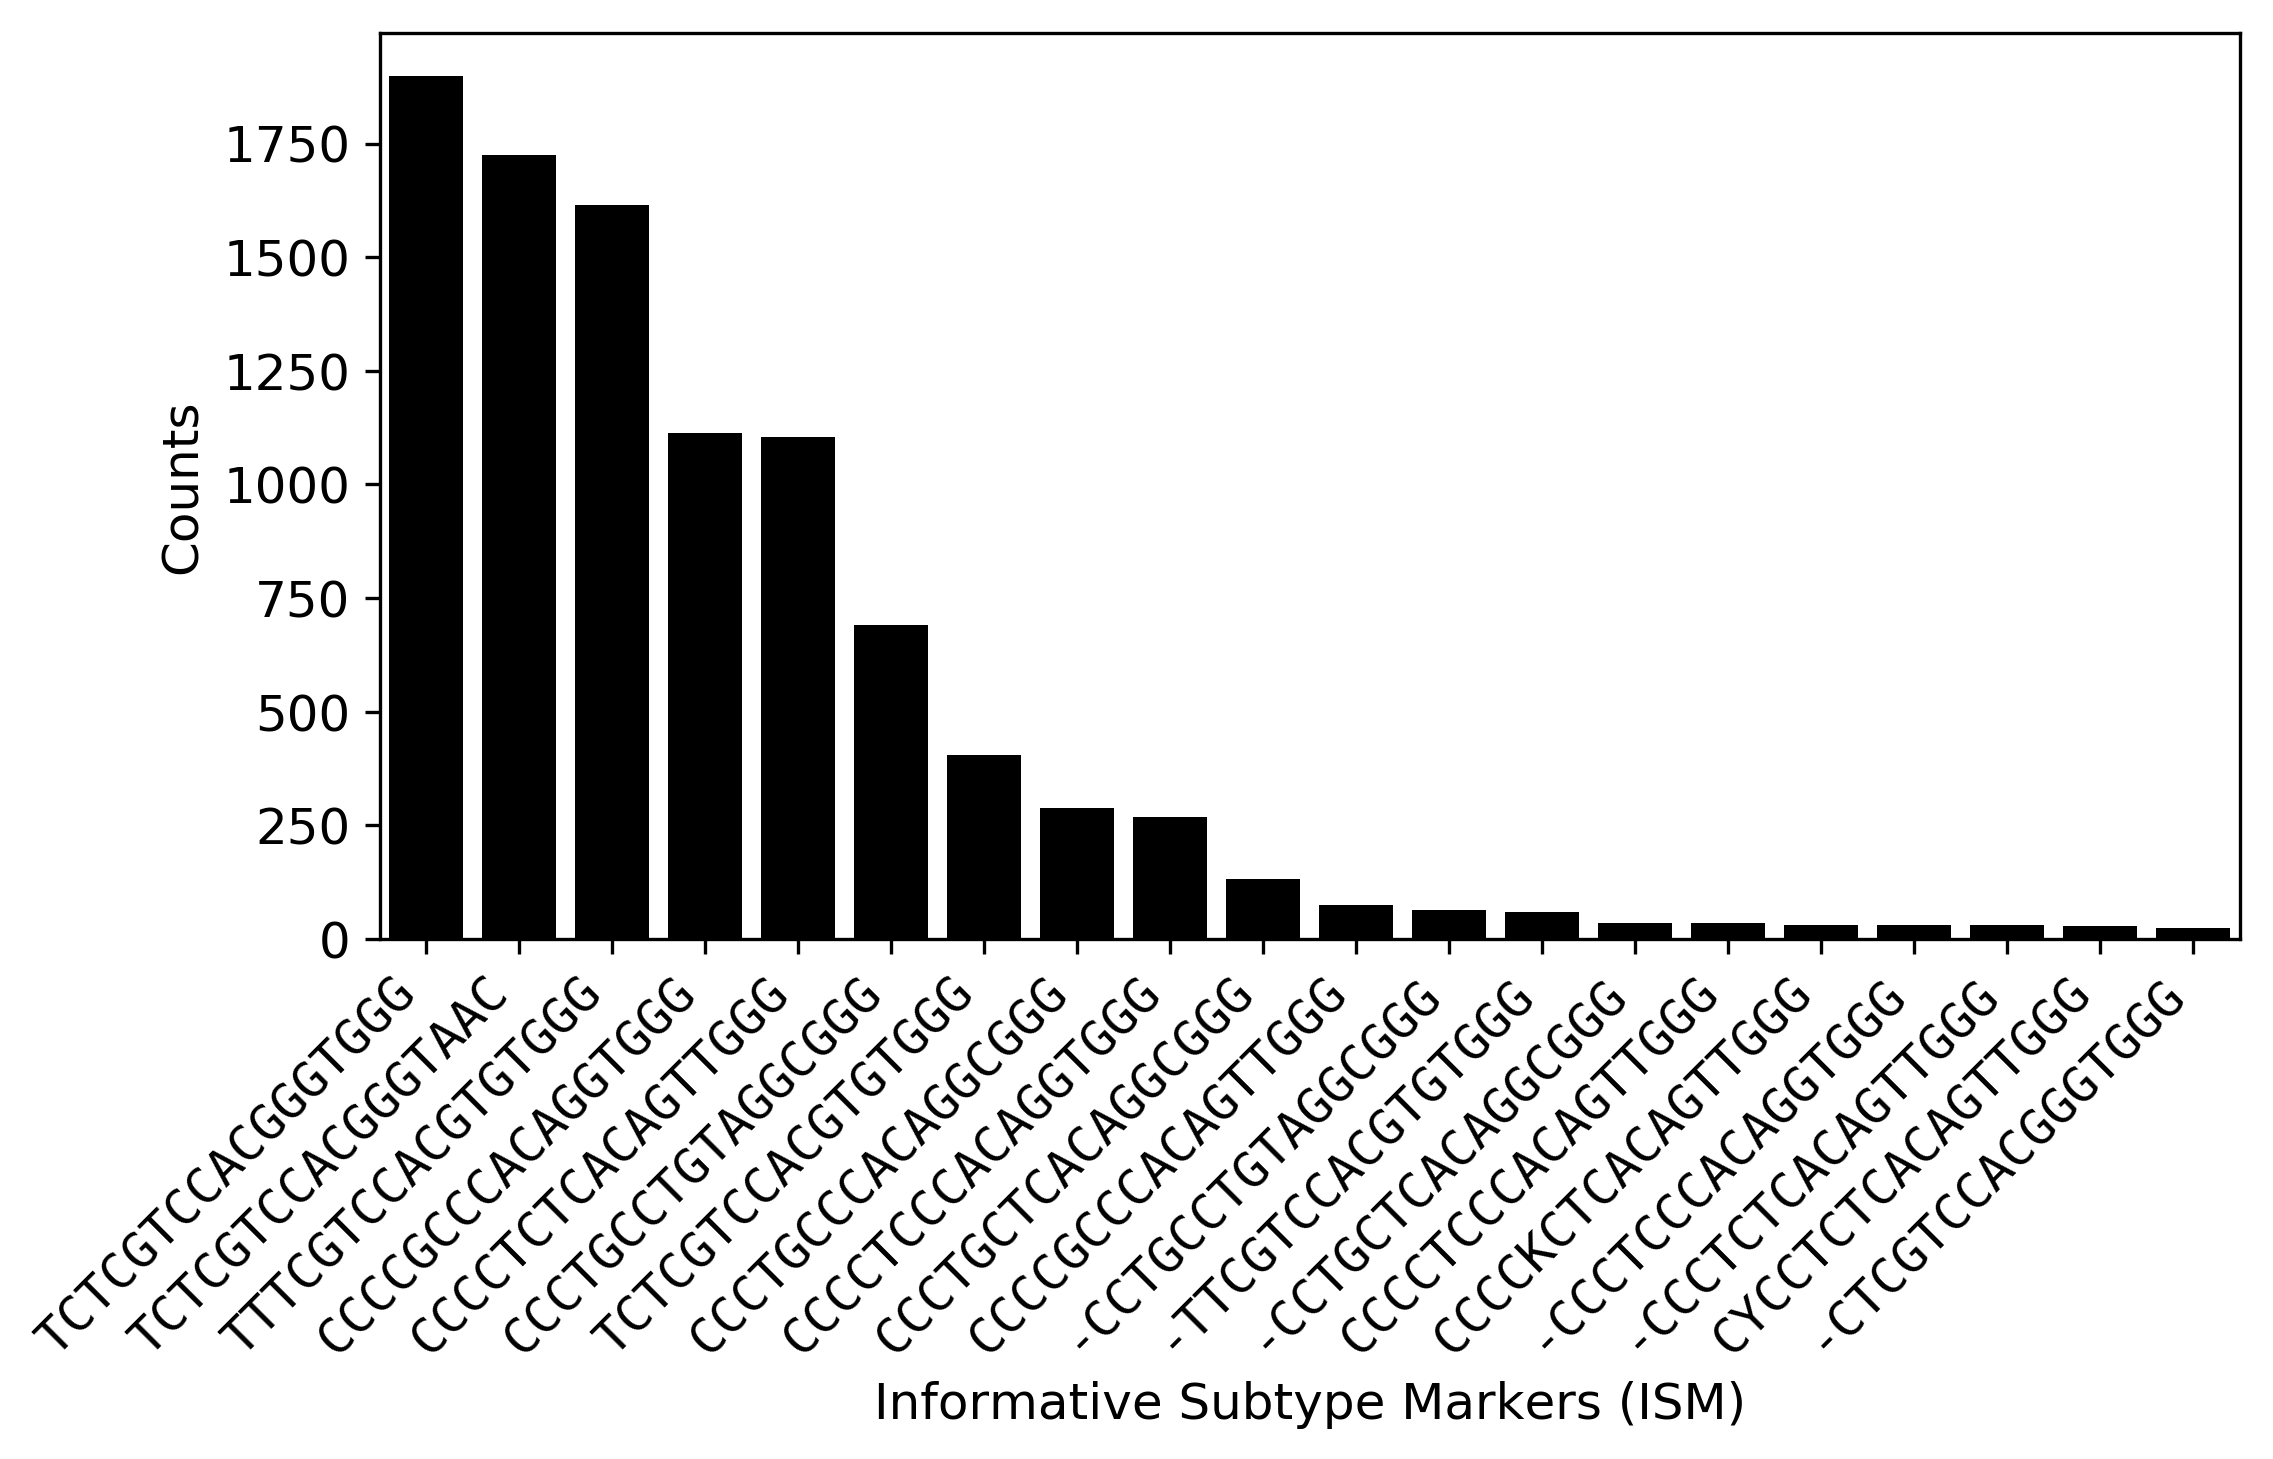

In [27]:
fig = plt.figure(figsize=(2400/DPI, 1200/DPI), dpi=DPI)   

x = np.arange(len(top_key_list))

plt.bar(x, top_value_list, color = 'black')
# plt.xticks(x, top_key_list, rotation = -45, ha='left',**monospace_font)
plt.xticks(x, top_key_list, rotation = 45, ha='right',**monospace_font)
plt.xlabel('Informative Subtype Markers (ISM)')
plt.ylabel('Counts')
plt.xlim([-0.5, len(top_value_list)-0.5])
plt.savefig('{}/4_ISM_histogram.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()

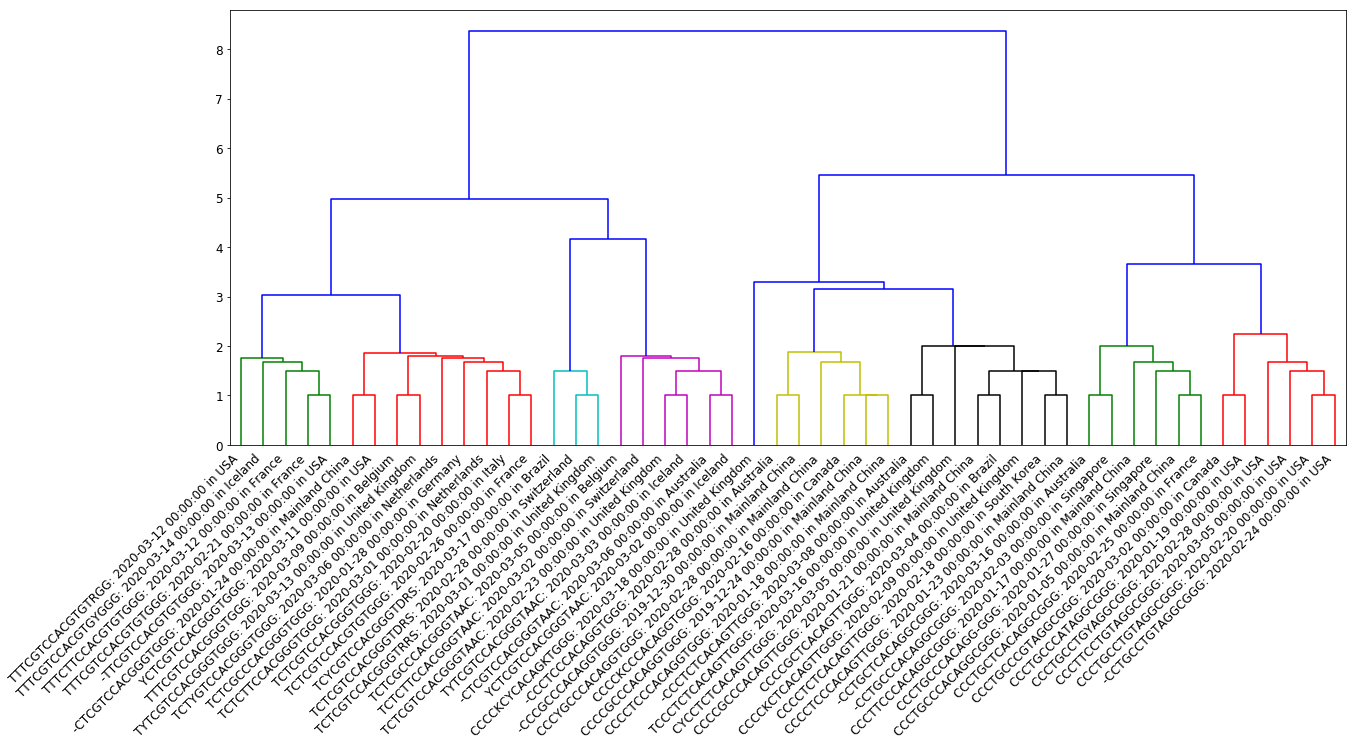

In [28]:
def hamming_dist(str1, str2):
    # assuming same length
    d = 0
    for i in range(len(str1)):
        if str1[i] == str2[i]:
            continue
        d += 1
    return d

K = 50
key_list = []
value_list = []
for ISM, counts in ISM_df['ISM'].value_counts().items():
    key_list.append(ISM)
    value_list.append(counts)
top_key_list = key_list[:K]
top_value_list = value_list[:K]

ISM_country = {}
for ISM in top_key_list:
    temp = ISM_df[ISM_df['ISM'] == ISM].groupby(['country/region']).agg({'date': 'min'}).reset_index()
    ISM_country[ISM] = '{} in {}'.format(temp['date'].min(), temp.iloc[temp['date'].idxmin()]['country/region'])

dated_label = ['{}: {}'.format(ISM, ISM_country[ISM]) for ISM in top_key_list[:K]]

ISM_hamming_dist = []
for i in range(K):
    for j in range(i + 1, K):
        ISM1 = top_key_list[i]
        ISM2 = top_key_list[j]
        d = hamming_dist(ISM1, ISM2)
        ISM_hamming_dist.append(d)
from scipy.cluster.hierarchy import dendrogram, linkage

font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font) 

linked = linkage(ISM_hamming_dist, 'average')

fig, ax = plt.subplots(figsize=(20,8))
dendrogram(linked,
            orientation='top',
            labels=dated_label,
            distance_sort='descending',
            color_threshold=3,
            leaf_font_size=12,
            show_leaf_counts=True)
plt.setp(ax.get_xticklabels(), ha='right', rotation=45)
plt.savefig('{}/4_top_ISM_tree.pdf'.format(output_folder), bbox_inches='tight')
plt.show()

In [29]:
ISM_dist_time = []
REFERENCE_date = ISM_df[ISM_df['ISM'] == REFERENCE_ISM]['date'].min().date()
max_date = REFERENCE_date
for i in range(K):
    ISM = top_key_list[i]
    d = hamming_dist(REFERENCE_ISM, ISM)
    ISM_date = ISM_df[ISM_df['ISM'] == ISM]['date'].min().date()
    if ISM_date > max_date:
        max_date = ISM_date
    delta = ISM_date - REFERENCE_date
    ISM_dist_time.append((d, abs(delta.days)))

In [30]:
# !wget -O data/total_cases_20200421.csv https://covid.ourworldindata.org/data/ecdc/total_cases.csv

In [31]:
total_cases_df = pd.read_csv('data/total_cases_20200421.csv')
total_cases_df['date'] = pd.to_datetime(total_cases_df['date'])
world_date = total_cases_df[(total_cases_df['date'] >= REFERENCE_date) & (total_cases_df['date'] <= max_date)]['date']
world_cases = total_cases_df[(total_cases_df['date'] >= REFERENCE_date) & (total_cases_df['date'] <= max_date)]['World'].values
world_cases_time = []
for i in range(world_date.shape[0]):
    delta = world_date.iloc[i].date() - REFERENCE_date
    world_cases_time.append((world_cases[i], abs(delta.days)))

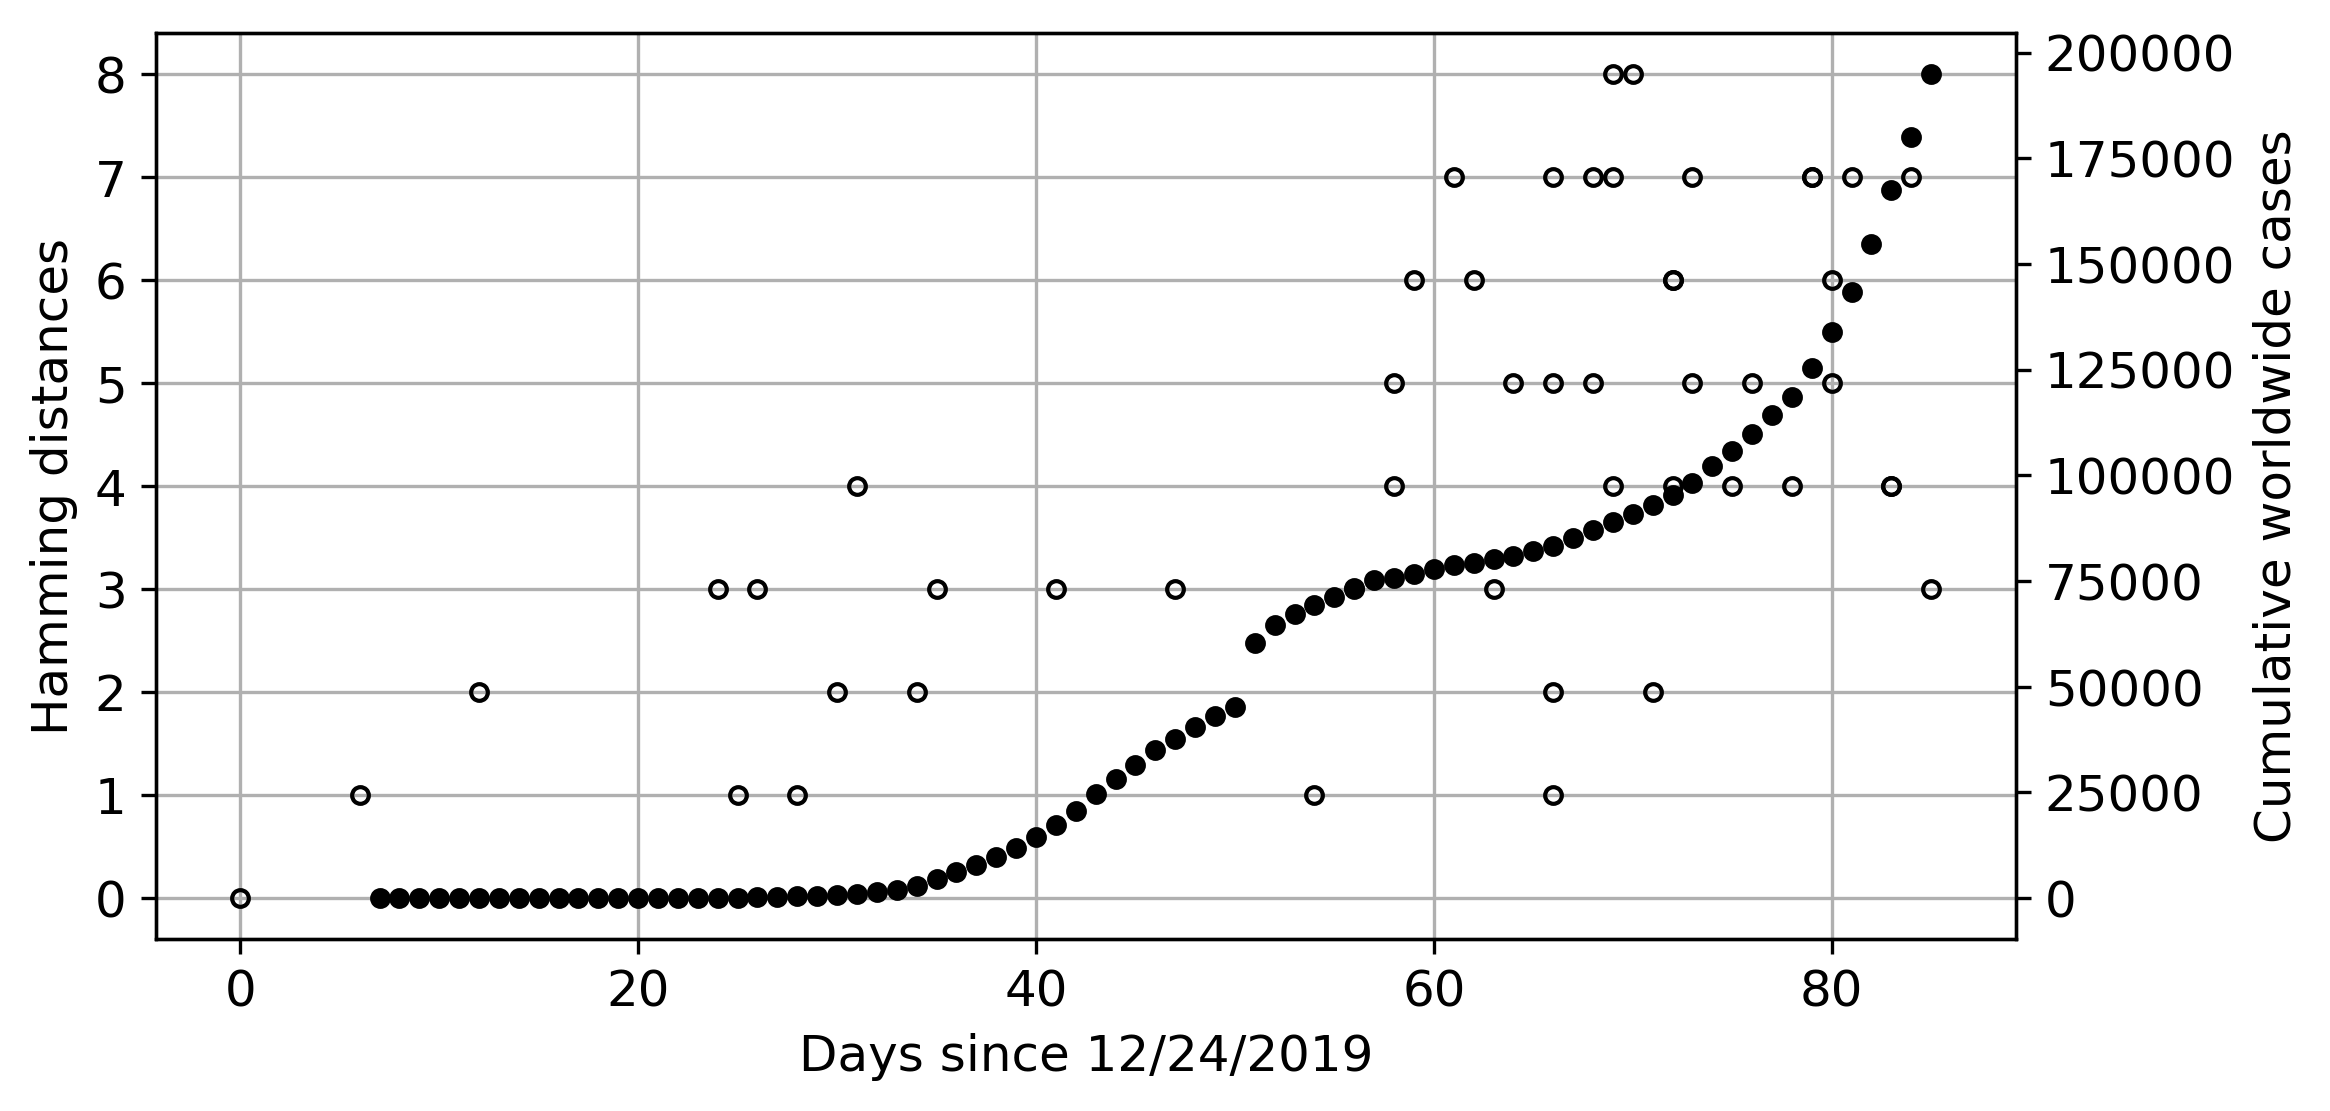

In [32]:
from scipy.stats import pearsonr
# corr, _ = pearsonr(np.array(ISM_time_difference)/np.max(ISM_time_difference), np.array(ISM_hamming_dist)/np.max(ISM_hamming_dist))
# title = 'Pearsons correlation: {:.3f}'.format(corr)
fig, ax1 = plt.subplots(figsize=(2400/DPI, 1200/DPI), dpi=DPI)
plt.grid()
ax1.set_xlabel('Days since 12/24/2019')
ax1.set_ylabel('Hamming distances')
plt.plot([x[1] for x in ISM_dist_time], [x[0] for x in ISM_dist_time], markersize = 4, marker='o', linestyle='None', color='black', mfc='none')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative worldwide cases') 
ax2.plot([x[1] for x in world_cases_time], [x[0] for x in world_cases_time], markersize = 4, marker='o', linestyle='None', color='black')
ax2.tick_params(axis='y')

plt.savefig('{}/4_hamming_distance_vs_time.pdf'.format(output_folder), bbox_inches='tight')
plt.show()

# ISM analysis
1. regional ISM composition (worldwide and intra-US) pie chart
2. temporal ISM composition change

In [33]:
# Record all ISMs in figures to assign colors
ISM_set = set([])

In [34]:
region_first_date = ISM_df.groupby(['country/region','ISM']).agg({'date': 'min'}).reset_index()
region_ISM_count = ISM_df.groupby('country/region')['ISM'].value_counts().to_frame()
region_ISM_count = region_ISM_count.rename(columns={'ISM': 'count'}).reset_index()
region_ISM_count_date = region_ISM_count.join(region_first_date.set_index(['country/region','ISM']), on = ['country/region','ISM'],how = 'left')

In [35]:
IMS_FILTER_THRESHOLD = 0.05
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong',
                'Australia', 'USA', 'Canada', 'Brazil',
                'United Kingdom', 'Iceland', 'Belgium', 'Netherlands',
                'France', 'Italy', 'Spain', 'Germany', 
               ]
region_pie_chart = {}
region_raw_count = {}
for idx, region in enumerate(region_list):
    dict_freq = regional_analysis(region_ISM_count_date, region)
    region_raw_count[region] = dict_freq
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    region_pie_chart[region] = dict_freq_filtered
    ISM_set.update(dict_freq_filtered.keys())

In [36]:
region_table = {'country/region': [], 'ISM': [], 'first seen': [], 'count': []}
for region in region_raw_count:
    for ISM in region_raw_count[region]:
        count = region_raw_count[region][ISM][1]
        first_seen = region_raw_count[region][ISM][0]
        region_table['country/region'].append(region)
        region_table['ISM'].append(ISM)
        region_table['first seen'].append(first_seen)
        region_table['count'].append(count)
region_table = pd.DataFrame.from_dict(region_table)
region_table.to_csv('{}/subtypes_in_region.csv'.format(output_folder), index=False)

In [37]:
intra_use_first_date = ISM_df[ISM_df['country/region'] == 'USA'].groupby(['division','ISM']).agg({'date': 'min'}).reset_index()
intra_usa_ISM_count = ISM_df[ISM_df['country/region'] == 'USA'].groupby('division')['ISM'].value_counts().to_frame()
intra_usa_ISM_count = intra_usa_ISM_count.rename(columns={'ISM': 'count'}).reset_index()
intra_usa_ISM_count_date = intra_usa_ISM_count.join(intra_use_first_date.set_index(['division','ISM']), on = ['division','ISM'],how = 'left')

In [38]:
state_count_thres = 15
state_list = [state for state, count in ISM_df[ISM_df['country/region'] == 'USA']['division'].value_counts().items() if count > state_count_thres]

In [39]:
IMS_FILTER_THRESHOLD = 0.05

state_pie_chart = {}
state_raw_count = {}
for idx, state in enumerate(state_list):
    dict_freq = statewise_analysis(intra_usa_ISM_count_date, state)
    state_raw_count[state] = dict_freq
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    state_pie_chart[state] = dict_freq_filtered
    ISM_set.update(dict_freq_filtered.keys())

In [40]:
state_table = {'location': [], 'ISM': [], 'first seen': [], 'count': []}
for region in state_raw_count:
    for ISM in state_raw_count[region]:
        count = state_raw_count[region][ISM][1]
        first_seen = state_raw_count[region][ISM][0]
        state_table['location'].append(region)
        state_table['ISM'].append(ISM)
        state_table['first seen'].append(first_seen)
        state_table['count'].append(count)
state_table = pd.DataFrame.from_dict(state_table)
state_table.to_csv('{}/subtypes_intra_US.csv'.format(output_folder), index=False)

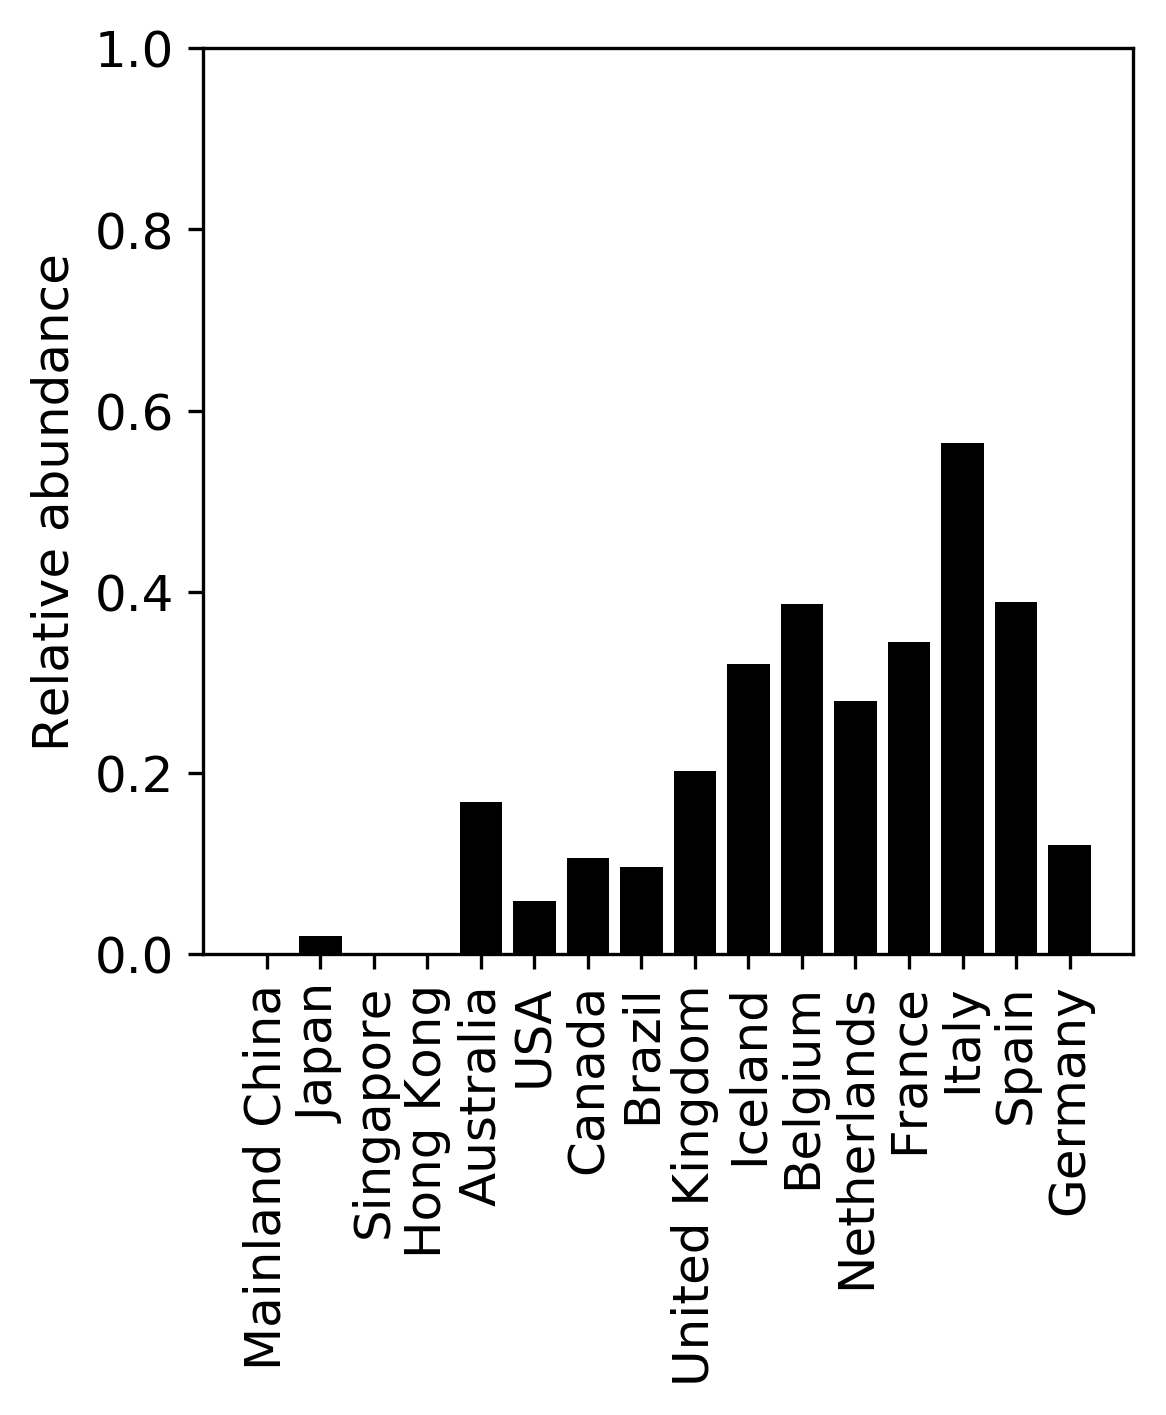

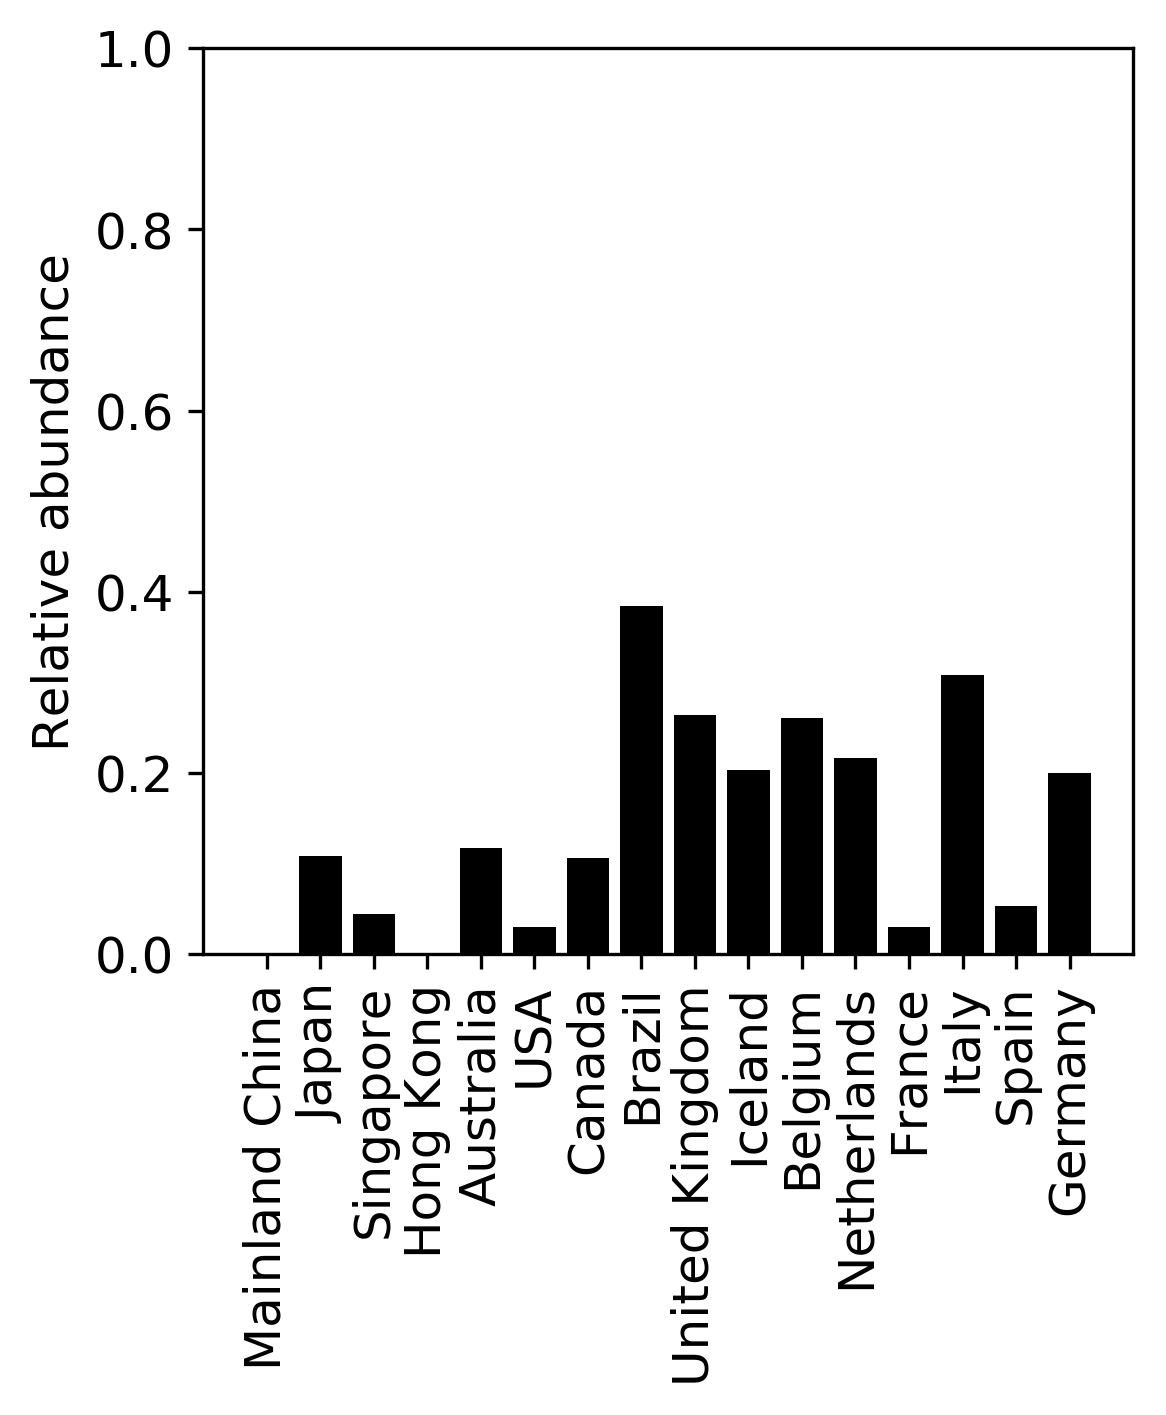

In [41]:
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong',
                'Australia', 'USA', 'Canada', 'Brazil',
                'United Kingdom', 'Iceland', 'Belgium', 'Netherlands',
                'France', 'Italy', 'Spain', 'Germany', 
               ]
for TYPICAL_ISM in ['TCTCGTCCACGGGTGGG', 'TCTCGTCCACGGGTAAC']:
    ISM_cross_regions = regional_typical_ISM_bar(TYPICAL_ISM, region_list, region_raw_count)
    fig = plt.figure(figsize=(1200/DPI, 1200/DPI), dpi=DPI)   

    x = np.arange(len(region_list))
    plt.ylim([0, 1])
    plt.bar(x, ISM_cross_regions, color = 'black')
    plt.xticks(x, region_list, rotation = 90)
    plt.ylabel('Relative abundance')
    plt.savefig('{}/5_TYPICAL_ISM_{}_histogram.pdf'.format(output_folder, TYPICAL_ISM), bbox_inches='tight', dpi=DPI)
    plt.show()

In [42]:
IMS_FILTER_THRESHOLD = 0.025

start_date = datetime.date(2019, 12, 1)
end_date = datetime.date(2020, 4, 1)
delta = datetime.timedelta(days=1)
region_list = ['Mainland China', 'USA', 'United Kingdom', 'Netherlands', 'Australia', 'Canada', 'Spain']
count_list = []
date_list = []
world_total_list = []
while start_date <= end_date:
    df_tmp = time_subset(ISM_df, '2019-11-01', str(start_date))
    if df_tmp.shape[0] == 0:
        start_date += delta
        continue
    world_total_list.append(df_tmp.shape[0])
    df_tmp_tmp = frequency_count(df_tmp)
    dict_freq = {}
    for region in region_list:
        regional_dict_freq = regional_timeseries_analysis(df_tmp_tmp, region)
        dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
        ISM_set.update(dict_freq_filtered.keys())
        dict_freq[region] = regional_dict_freq
    count_list.append(dict_freq)
    date_list.append(start_date)
    start_date += delta

Need 46 distinctive colors
Global color map:


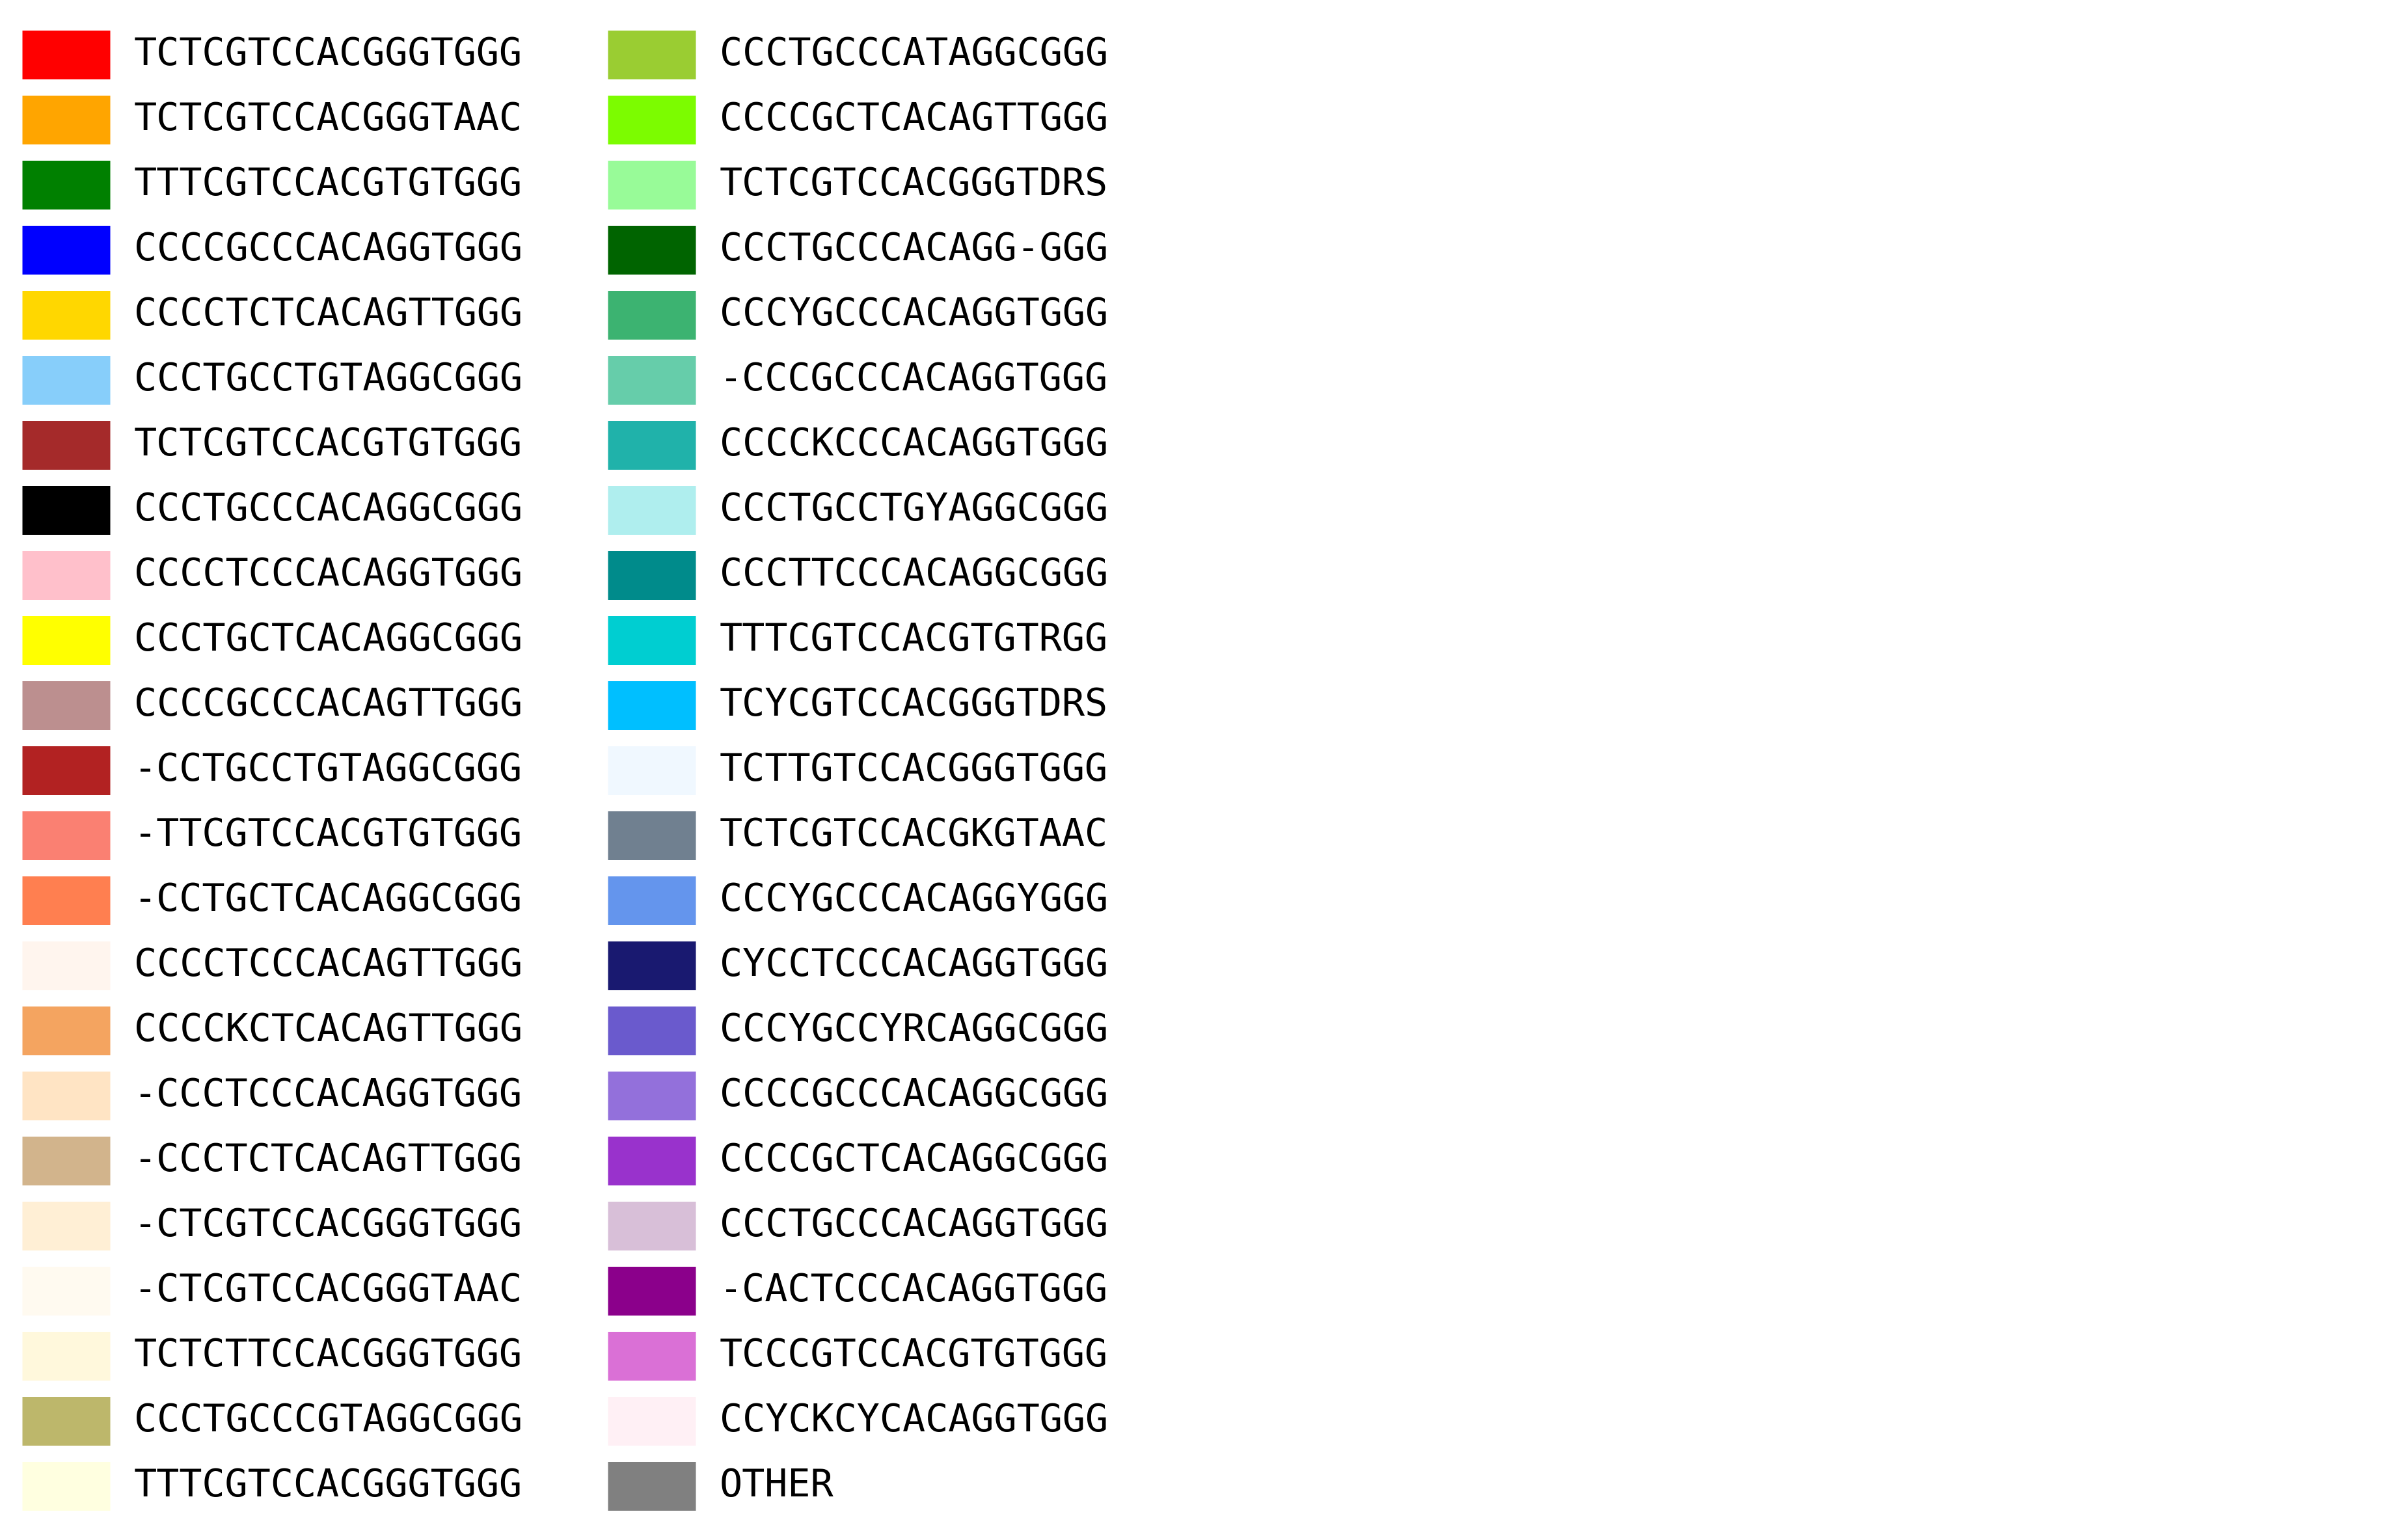

In [43]:
# Global color:
# assign color by frequency
print('Need {} distinctive colors'.format(len(ISM_set)))
ISM_list = []
for ISM in ISM_set:
    if ISM == 'OTHER':
        continue
    ISM_list.append((ISM, ISM_index[ISM]))
ISM_list = sorted(ISM_list, key = lambda x: x[1])
ISM_list = [item[0] for item in ISM_list]
# COLOR MAP METHOD 1
CSS4_COLORS = mcolors.CSS4_COLORS
color_map = get_color_names(CSS4_COLORS, len(ISM_list))
COLOR_DICT = {}
for idx, ISM in enumerate(ISM_list):
    COLOR_DICT[ISM] = color_map[idx]
COLOR_DICT['OTHER'] = 'gray'
print('Global color map:')
global_color_map(COLOR_DICT, ISM_list, out_dir=output_folder)
# COLOR MAP METHOD 2
# color_map = ['red', 'orange', 'green', 'blue', 'gold', 
#              'lightskyblue', 'brown', 'gray', 'pink',
#              'yellow', 'purple', 'goldenrod', 'violet', 
#              'burlywood', 'tan', 'chocolate', 
#              'salmon', 'coral', 'moccasin', 'darkseagreen',
#              'lime', 'teal', 'darkturquoise', 'navy',
#              'rosybrown', 'navajowhite', 'khaki', 'deepskyblue',
#              'indigo', 'magenta', 'darkred', 'saddlebrown', 
#              'greenyellow', 'darkmagenta'
#             ]
# COLOR_DICT = {}
# for idx, ISM in enumerate(ISM_list):
#     COLOR_DICT[ISM] = color_map[idx]
# COLOR_DICT['OTHER'] = 'black'

In [44]:
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:d}".format(absolute)
def plot_pie_chart(sizes, labels, colors, ax):
    wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes), colors = colors, textprops=dict(color="w"))
    time_labels = ['-' if label == 'OTHER' else label.split(' ')[1] for label in labels]
    ax.legend(wedges, time_labels,
#           title="Oligotypes",
          loc="lower left",
          bbox_to_anchor=(0.8, 0, 0.5, 1))
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    return wedges, labels

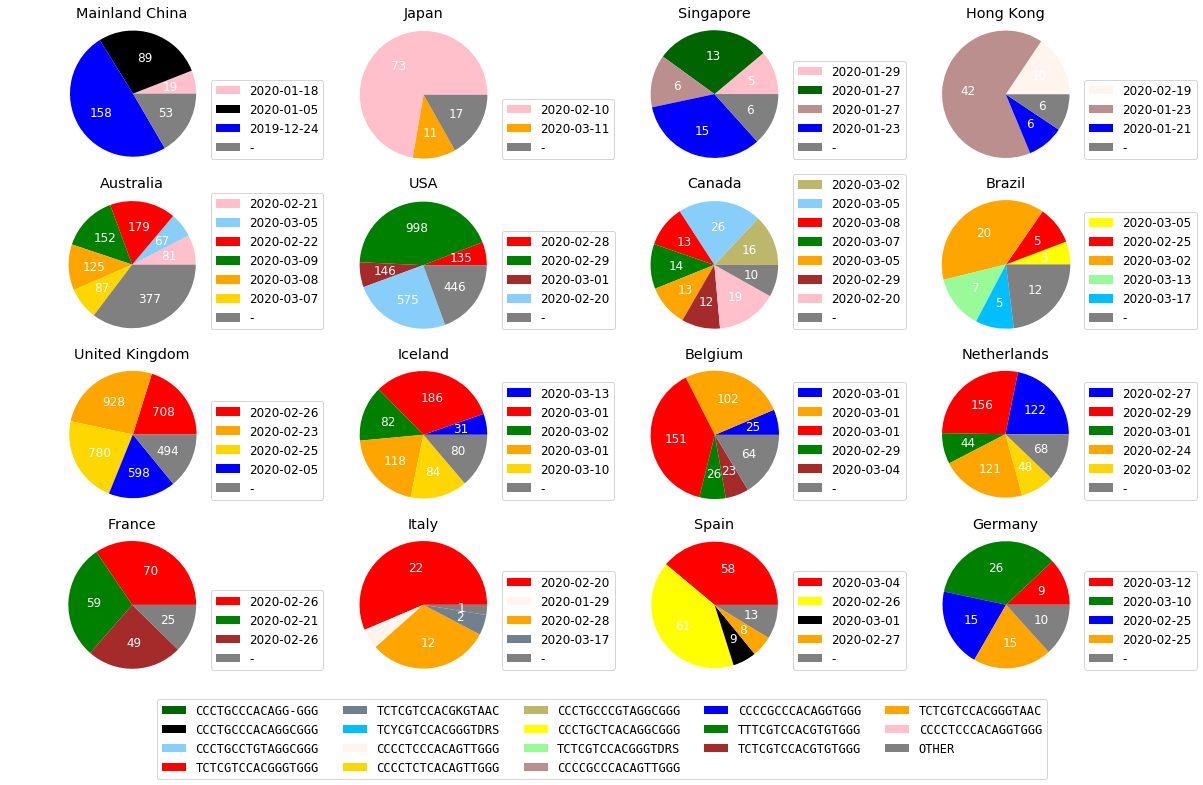

In [45]:
# fig = plt.figure(figsize=(2100/DPI, 2100/DPI), dpi=DPI)   
fig = plt.figure(figsize=(20, 12))   
region_list = ['Mainland China', 'Japan', 'Singapore', 'Hong Kong',
                'Australia', 'USA', 'Canada', 'Brazil',
                'United Kingdom', 'Iceland', 'Belgium', 'Netherlands',
                'France', 'Italy', 'Spain', 'Germany', 
               ]

# region_list = ['Mainland China', 'Japan', 'Singapore',
#                 'Australia', 'USA', 'Canada', 
#                 'United Kingdom', 'Netherlands', 'France', 
#                'Italy', 'Spain', 'Germany', 
#                ]
wedges_list = []
for idx, region in enumerate(region_list):
    dict_freq = region_pie_chart[region]
    total = sum([dict_freq[ISM][1] for ISM in dict_freq])
    labels = []
    sizes = []
    colors = []

    for ISM in dict_freq:
        if ISM == 'OTHER':
            continue
        labels.append('{}: {}'.format(ISM, np.datetime_as_string(dict_freq[ISM][0], unit='D')))
        colors.append(COLOR_DICT[ISM])
        sizes.append(dict_freq[ISM][1])
    if 'OTHER' in dict_freq:
        labels.append('OTHER')
        colors.append(COLOR_DICT['OTHER'])
        sizes.append(dict_freq['OTHER'][1])
    
    ax=plt.subplot(4, 4, idx+1)
    wedges, labels = plot_pie_chart(sizes, labels, colors, ax)
    ax.set_title(region)
    wedges_list.append((wedges, labels))

labels_handles = {}
handles_OTHER = None
for wedges, labels in wedges_list:
    for idx, label in enumerate(labels):
        label = label.split(':')[0]
        if label == 'OTHER':
            handles_OTHER = [wedges[idx], label]
            continue
        if label not in labels_handles:
            labels_handles[label] = wedges[idx]
if handles_OTHER:
    handles_list = list(labels_handles.values()) + [handles_OTHER[0]]
    labels_list = list(labels_handles.keys()) + [handles_OTHER[1]]
    fig.legend(
      handles_list,
      labels_list,
      loc="lower center",
#       bbox_to_anchor=(0.5, 0),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
else:
    fig.legend(
      labels_handles.values(),
      labels_handles.keys(),
      loc="lower center",
#       bbox_to_anchor=(0.5, 0),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
plt.savefig('{}/6_regional_ISM.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI, transparent=True)
plt.show()

In [46]:
IMS_FILTER_THRESHOLD = 0.05

state_pie_chart = {}
state_pie_raw = {}
for idx, state in enumerate(state_list):
    dict_freq = statewise_analysis(intra_usa_ISM_count_date, state)
    dict_freq_filtered = ISM_filter(dict_freq, IMS_FILTER_THRESHOLD)
    state_pie_chart[state] = dict_freq_filtered
    state_pie_raw[state] = dict_freq
    ISM_set.update(dict_freq_filtered.keys())

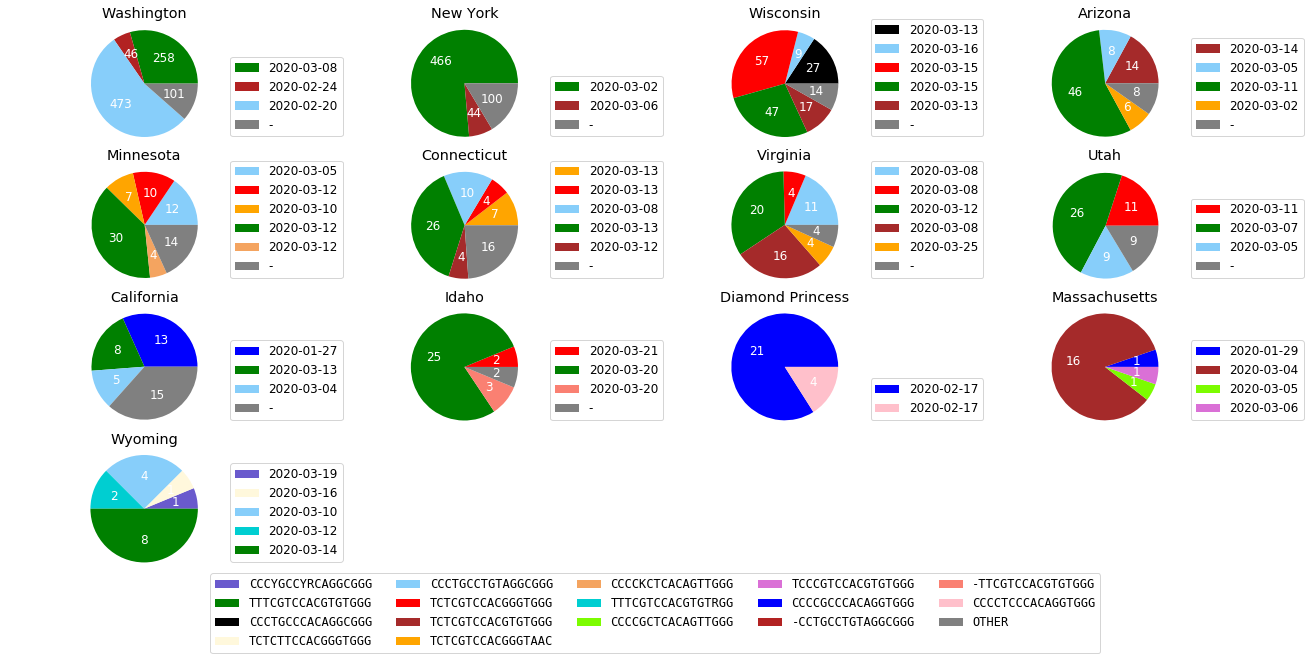

In [47]:
# fig = plt.figure(figsize=(2100/DPI, 2100/DPI), dpi=DPI)   
fig = plt.figure(figsize=(22, 10))   

subplot_y = int(np.sqrt(len(state_list)))
subplot_x = int(np.sqrt(len(state_list))) + 1

if subplot_x * subplot_y < len(state_list):
    subplot_y = subplot_x
    
wedges_list = []
for idx, state in enumerate(state_list):
    dict_freq = state_pie_chart[state]
    total = sum([dict_freq[ISM][1] for ISM in dict_freq])
    labels = []
    sizes = []
    colors = []

    for ISM in dict_freq:
        if ISM == 'OTHER':
            continue
        labels.append('{}: {}'.format(ISM, np.datetime_as_string(dict_freq[ISM][0], unit='D')))
        colors.append(COLOR_DICT[ISM])
        sizes.append(dict_freq[ISM][1])
    if 'OTHER' in dict_freq:
        labels.append('OTHER')
        colors.append(COLOR_DICT['OTHER'])
        sizes.append(dict_freq['OTHER'][1])
    
    ax=plt.subplot(subplot_x, subplot_y, idx+1)
    wedges, labels = plot_pie_chart(sizes, labels, colors, ax)
    ax.set_title(state)
    wedges_list.append((wedges, labels))

labels_handles = {}
handles_OTHER = None
for wedges, labels in wedges_list:
    for idx, label in enumerate(labels):
        label = label.split(':')[0]
        if label == 'OTHER':
            handles_OTHER = [wedges[idx], label]
            continue
        if label not in labels_handles:
            labels_handles[label] = wedges[idx]
if handles_OTHER:
    handles_list = list(labels_handles.values()) + [handles_OTHER[0]]
    labels_list = list(labels_handles.keys()) + [handles_OTHER[1]]
    fig.legend(
      handles_list,
      labels_list,
      loc="lower center",
#       bbox_to_anchor=(0.5, 0),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
else:
    fig.legend(
      labels_handles.values(),
      labels_handles.keys(),
      loc="lower center",
#       bbox_to_anchor=(0.5, 0),
      bbox_transform=plt.gcf().transFigure,
      ncol=5,
      prop={'family': monospace_font['fontname']}
    )
plt.savefig('{}/7_intra-US_ISM.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI, transparent=True)
plt.show()

In [48]:
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font) 
IMS_FILTER_THRESHOLD = 0.025

def regional_growth_plot(region, count_list, date_list):
    fig = plt.figure(figsize = (30, 15))
#     fig = plt.figure(figsize=(2100/DPI, 1200/DPI), dpi=DPI)   
    n = 4
    ax=plt.subplot(1, 1, 1)
    
    regional_total = []
    ISM_regional_set = set([])
    for i in range(len(count_list)):
        regional_dict_freq = count_list[i][region]
        regional_total.append(sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq]))
        dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
        ISM_regional_set.update(dict_freq_filtered.keys())
    ISM_regional_list = []
    for ISM in ISM_regional_set:
        if ISM != 'OTHER':
            ISM_regional_list.append(ISM)
    NONOTHER = len(ISM_regional_list)
    if 'OTHER' in ISM_regional_set:
        ISM_regional_list.append('OTHER')
#     y = np.zeros(len(count_list))
    for ISM in ISM_regional_list:
        ISM_regional_growth = []
            
        for i in range(len(count_list)):
            regional_dict_freq = count_list[i][region]
#      ======== old method 1 ========
#             dict_freq_filtered = ISM_filter(regional_dict_freq, IMS_FILTER_THRESHOLD)
#             if ISM in dict_freq_filtered and dict_freq_filtered[ISM][1]!= 0:
#                 ISM_regional_growth.append(dict_freq_filtered[ISM][1]/regional_total[i])
#             else:
#                 ISM_regional_growth.append(0)
#      ======== new method 2 ========
            if ISM in regional_dict_freq and regional_dict_freq[ISM][1]!= 0:
                ISM_regional_growth.append(regional_dict_freq[ISM][1]/regional_total[i])
            else:
                if ISM == 'OTHER':
                    other_count = sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq if ISM not in ISM_regional_set])
                    if regional_total[i] != 0:
                        ISM_regional_growth.append(other_count/regional_total[i])
                    else:
                        ISM_regional_growth.append(0)
                else:
                    ISM_regional_growth.append(0)
#         y += np.array(ISM_regional_growth)
        ax.plot(ISM_regional_growth, color = COLOR_DICT[ISM], label = ISM, linewidth = 4, marker = 'o', markersize = 4)
#     print(y)
    ####
#     IDX = -1
#     total = sum([count_list[IDX][region][item][1] for item in count_list[IDX][region]])
#     res = []
#     for item in count_list[IDX][region]:
#         if item not in ISM_regional_set:
#             res.append((item, count_list[IDX][region][item][1], count_list[IDX][region][item][1]/total))
#     if region == 'Canada':
#         print(res)
#     if len(res) != 0:
#         print('{}, {}, {}, {}'.format(region, *sorted(res, key=lambda x: x[1], reverse = True)[0]))
    ####
        
    major_ticks = np.arange(0, len(date_list), 5)
    minor_ticks = np.arange(0, len(date_list))
    major_label = []
    
    for i in major_ticks.tolist():
        major_label.append(str(date_list[i]))
#     print(major_label)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_label)
    plt.setp(ax.get_xticklabels(), rotation=90)
#     [l.set_visible(False) for (i,l) in enumerate(ax.axes.xaxis.get_ticklabels()) if i % n != 0]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend(#title="Oligotypes",
              loc="lower left",
              bbox_to_anchor=(1, 0, 0.5, 1),
              prop={'family': monospace_font['fontname']})
    plt.xlim([-1, len(date_list)])
    plt.ylabel('Relative abundance')
    ax.grid(which='minor', alpha=0.3, linestyle='--')
    ax.grid(which='major', alpha=0.8)
    plt.savefig('{}/8_ISM_growth_{}.pdf'.format(output_folder, region), bbox_inches='tight')
    plt.show()  

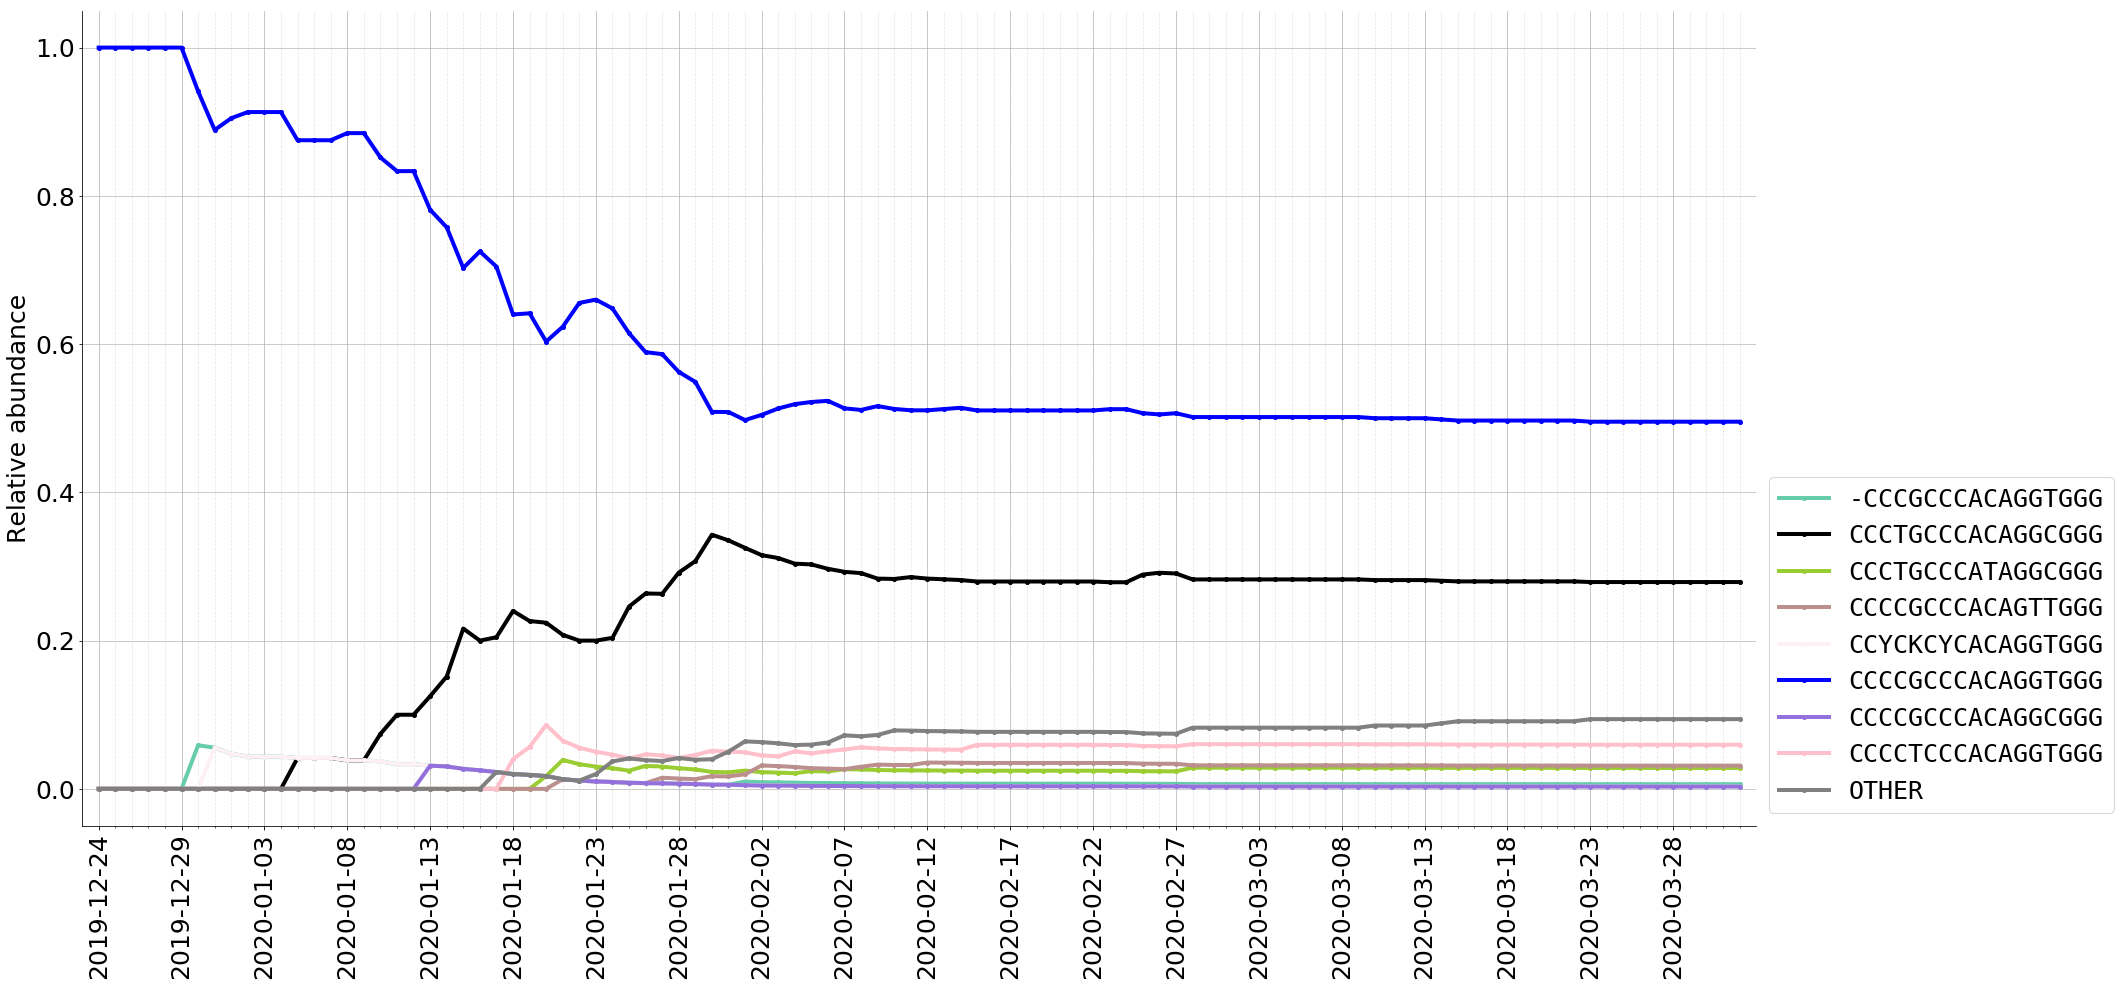

In [49]:
regional_growth_plot('Mainland China', count_list, date_list)

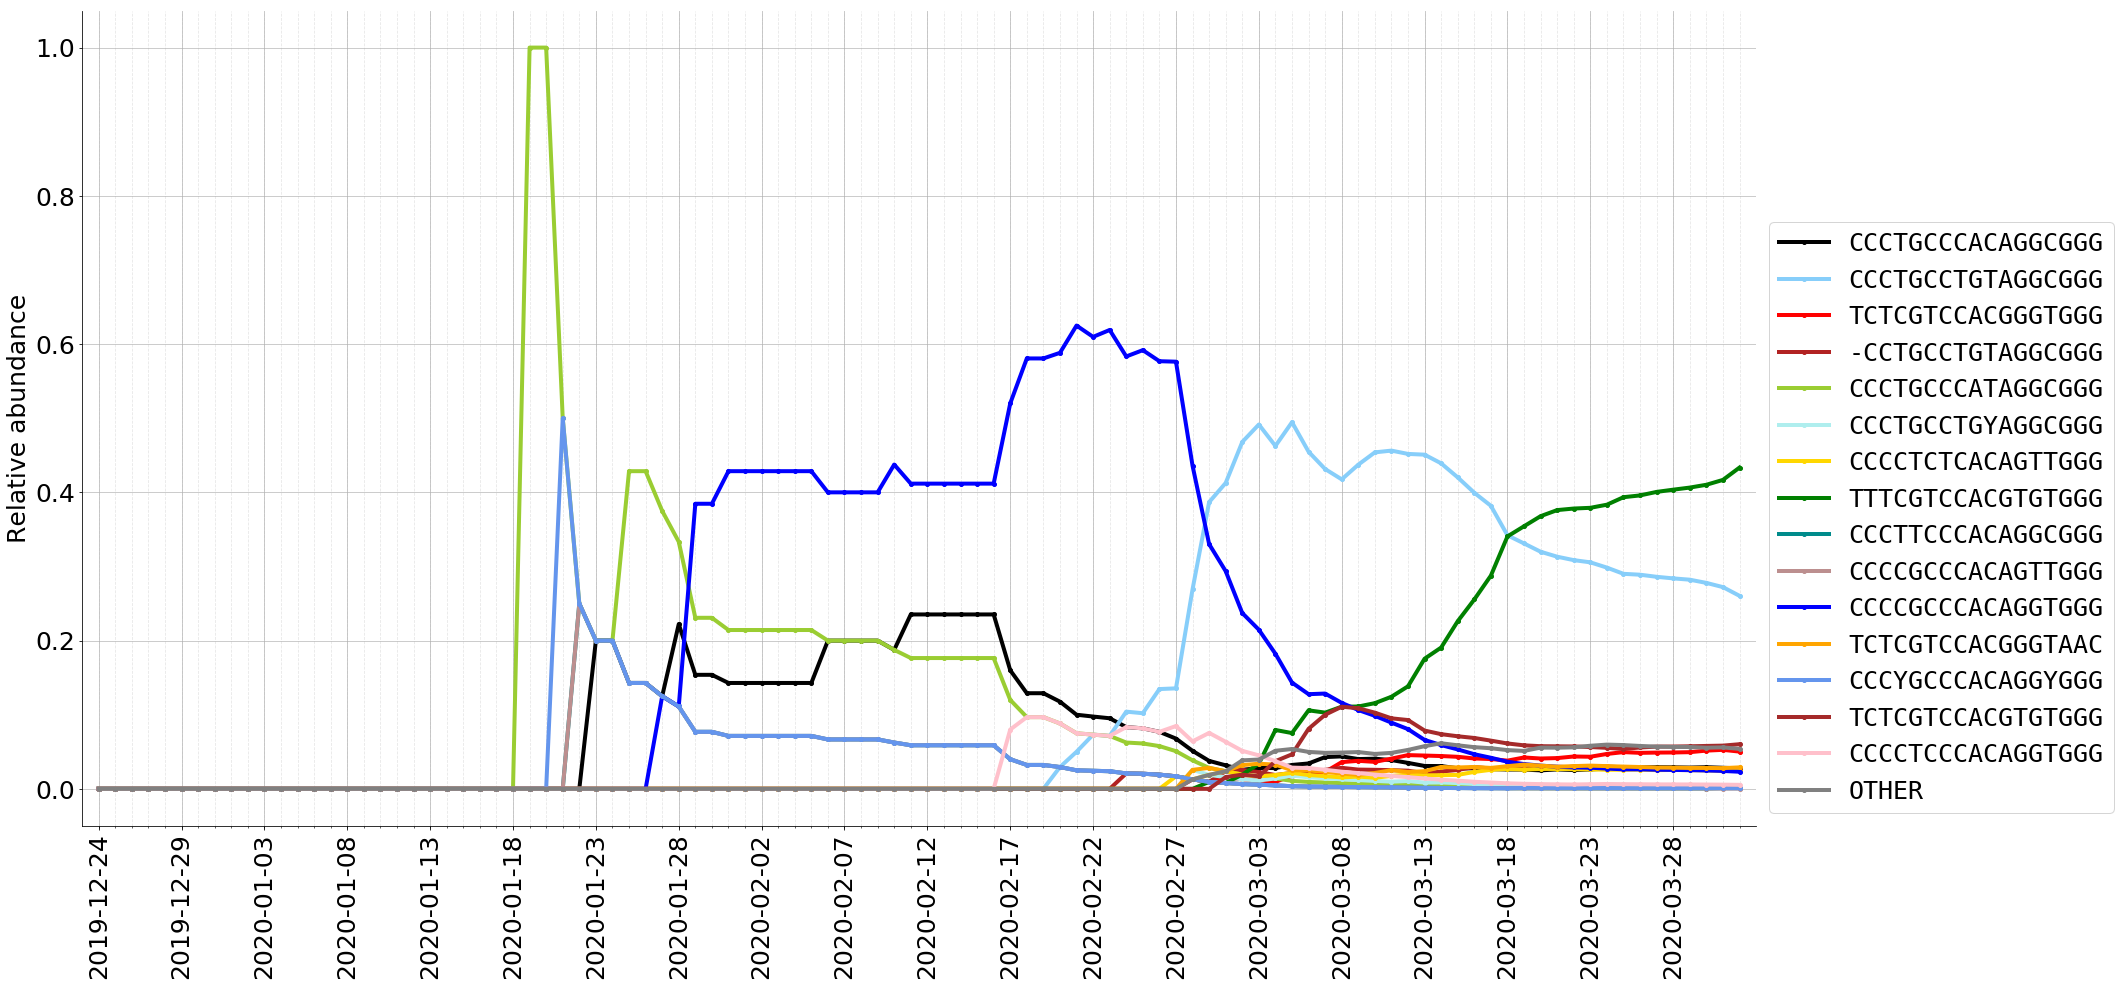

In [50]:
regional_growth_plot('USA', count_list, date_list)

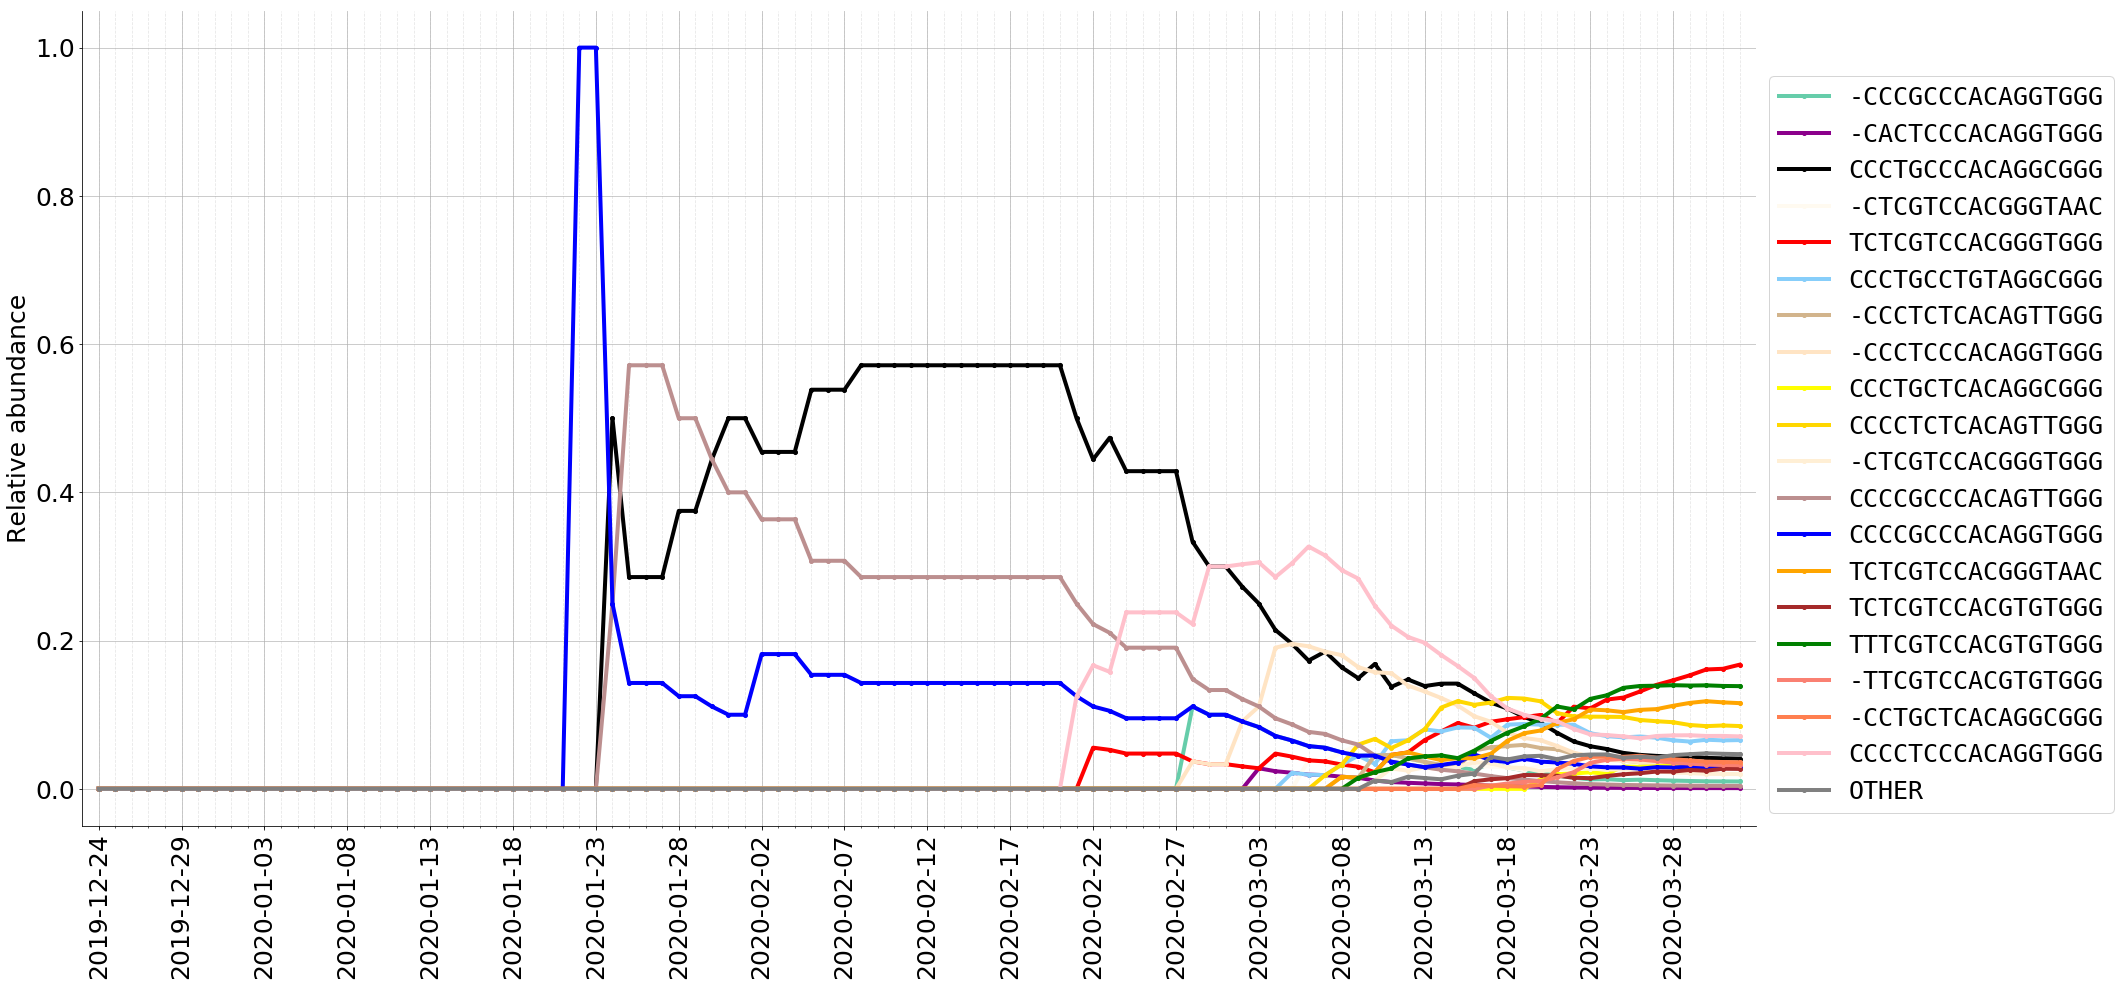

In [51]:
regional_growth_plot('Australia', count_list, date_list)

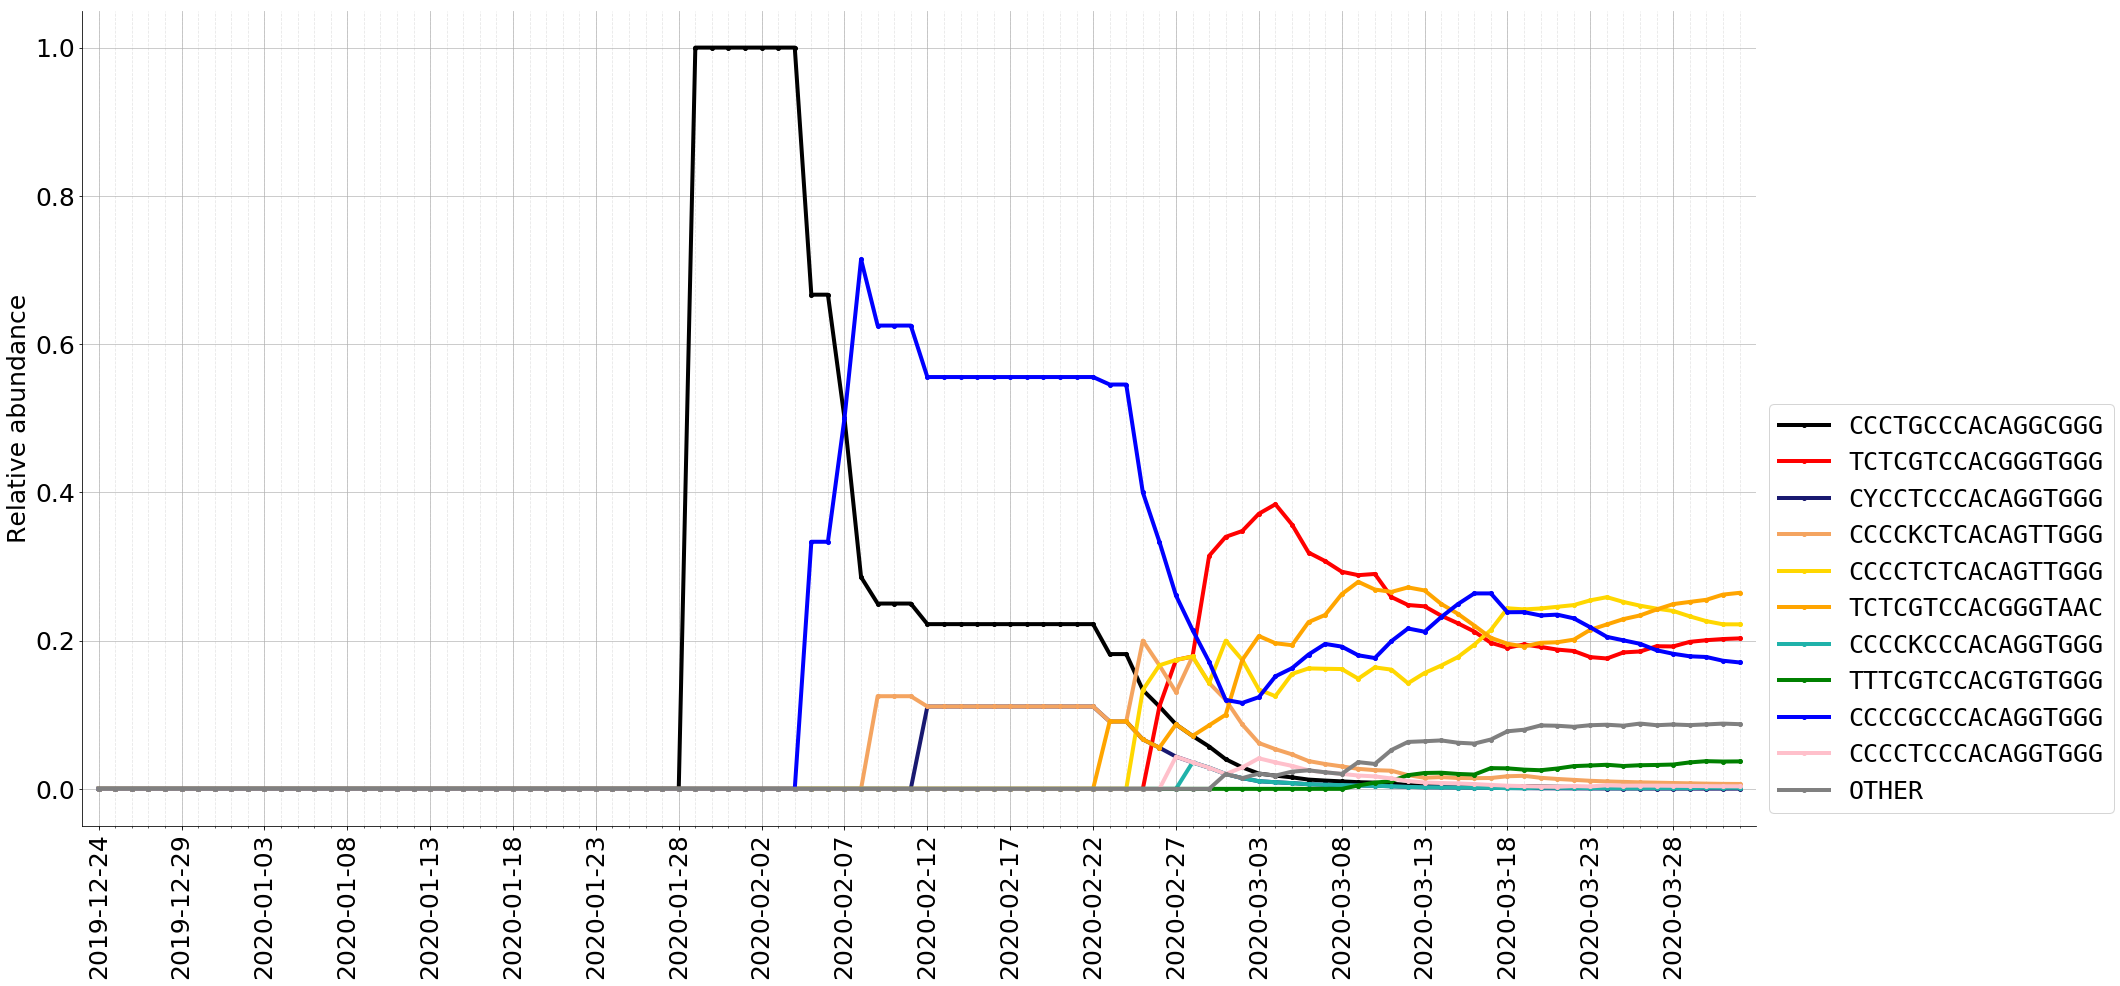

In [52]:
regional_growth_plot('United Kingdom', count_list, date_list)

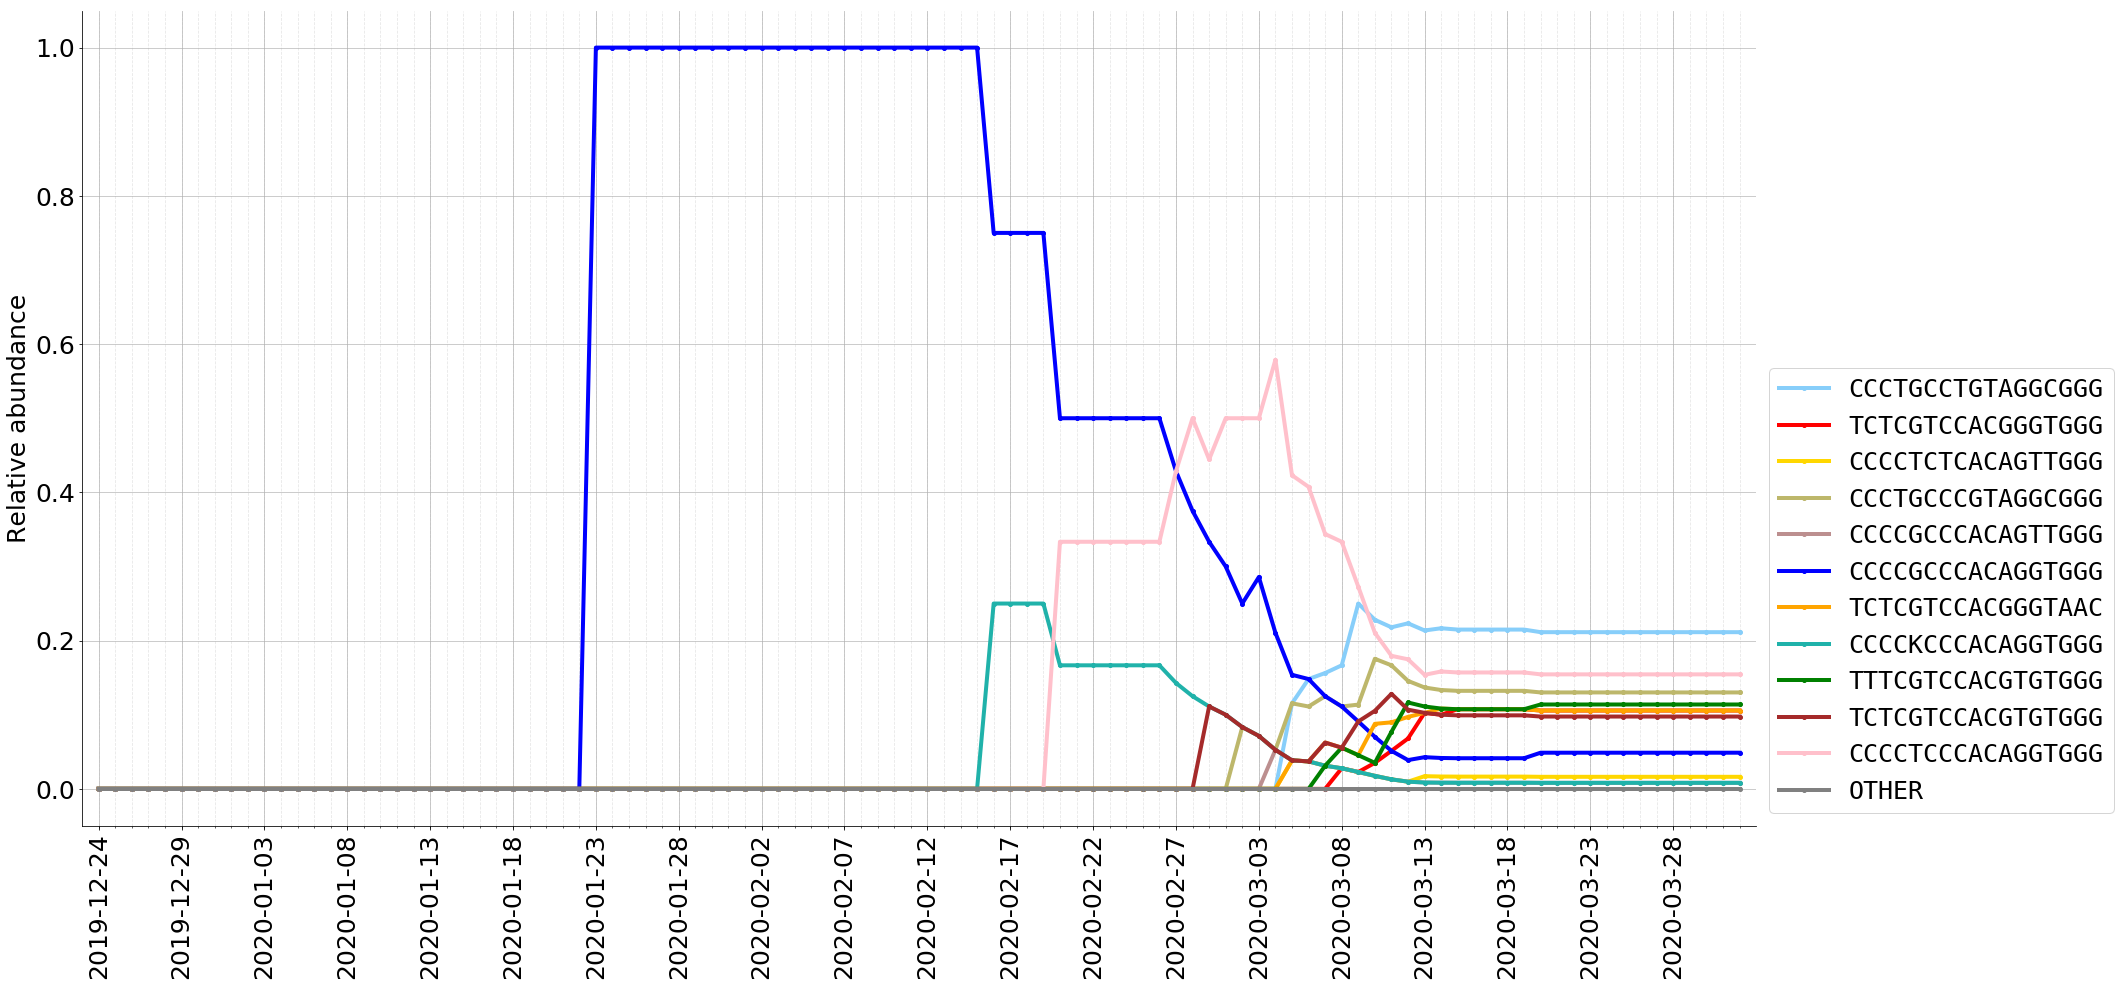

In [53]:
regional_growth_plot('Canada', count_list, date_list)

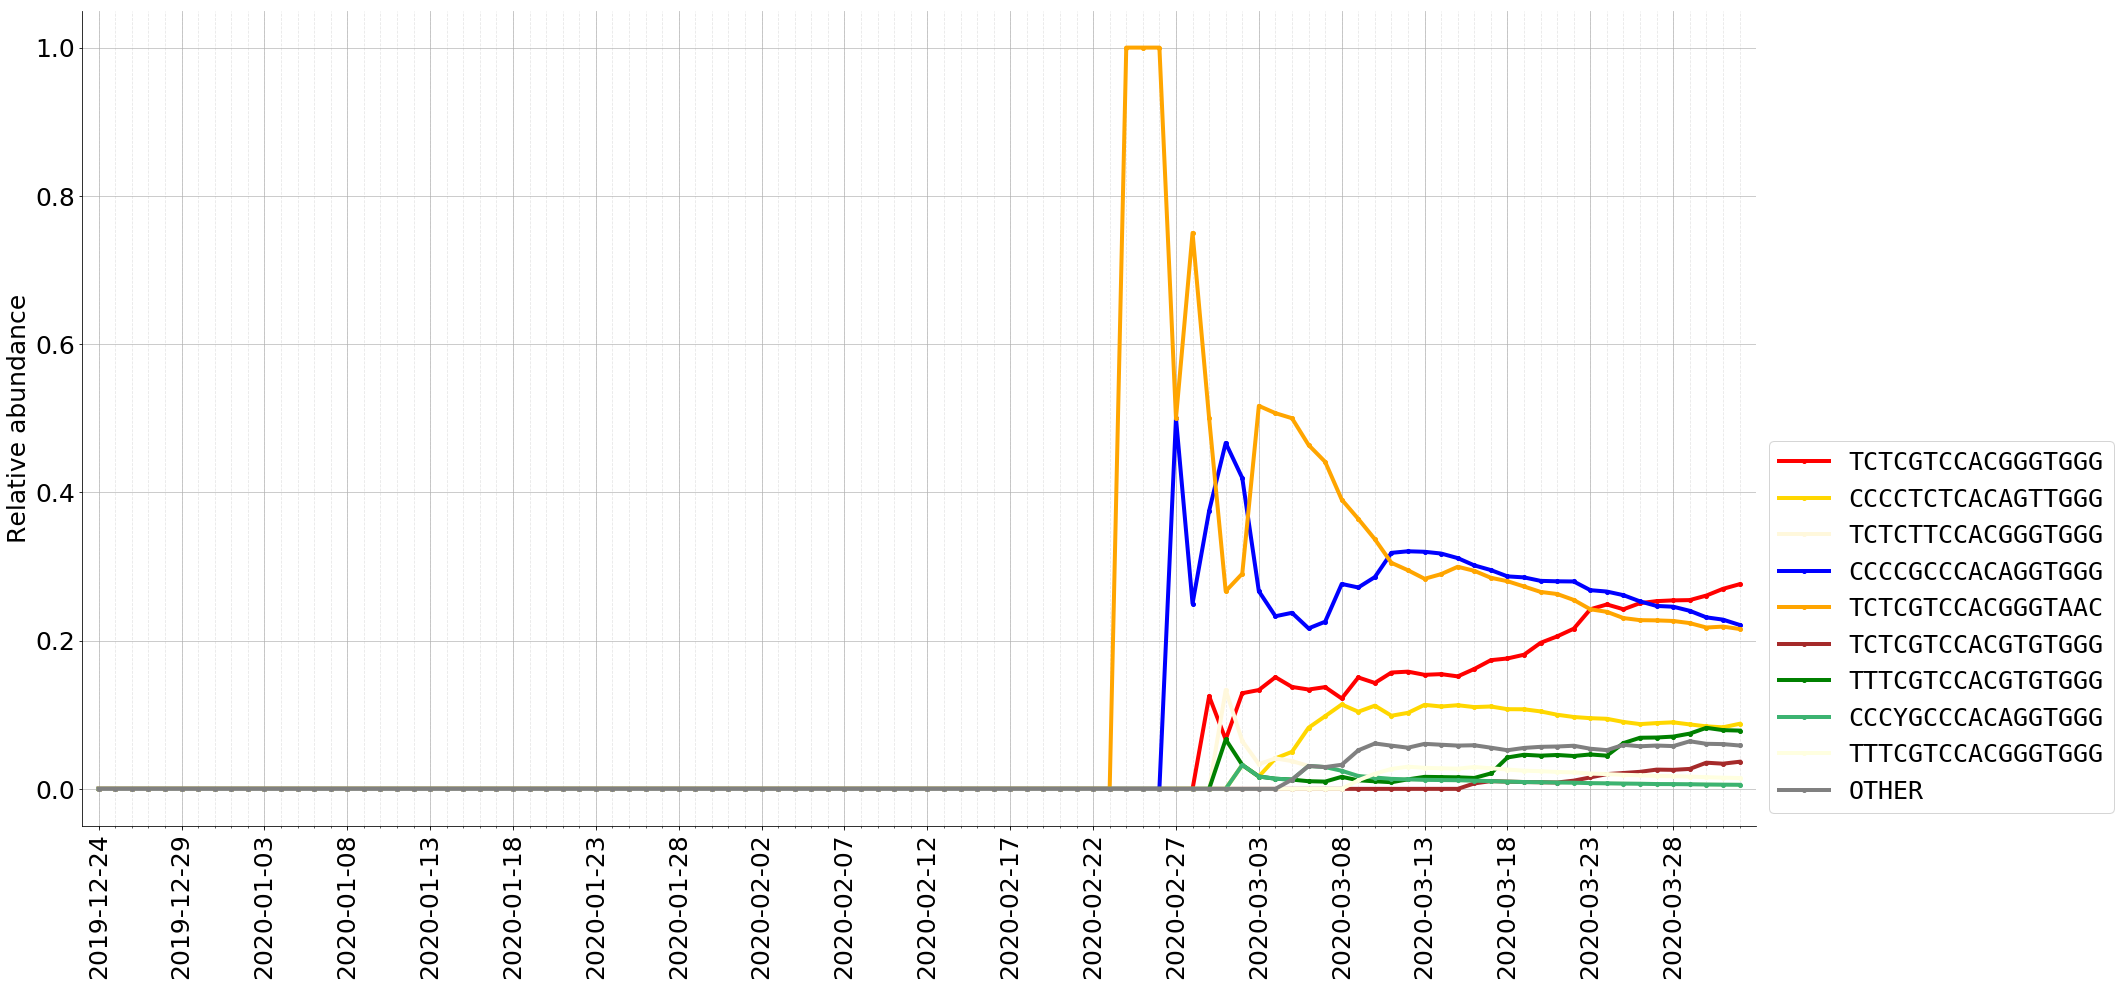

In [54]:
regional_growth_plot('Netherlands', count_list, date_list)

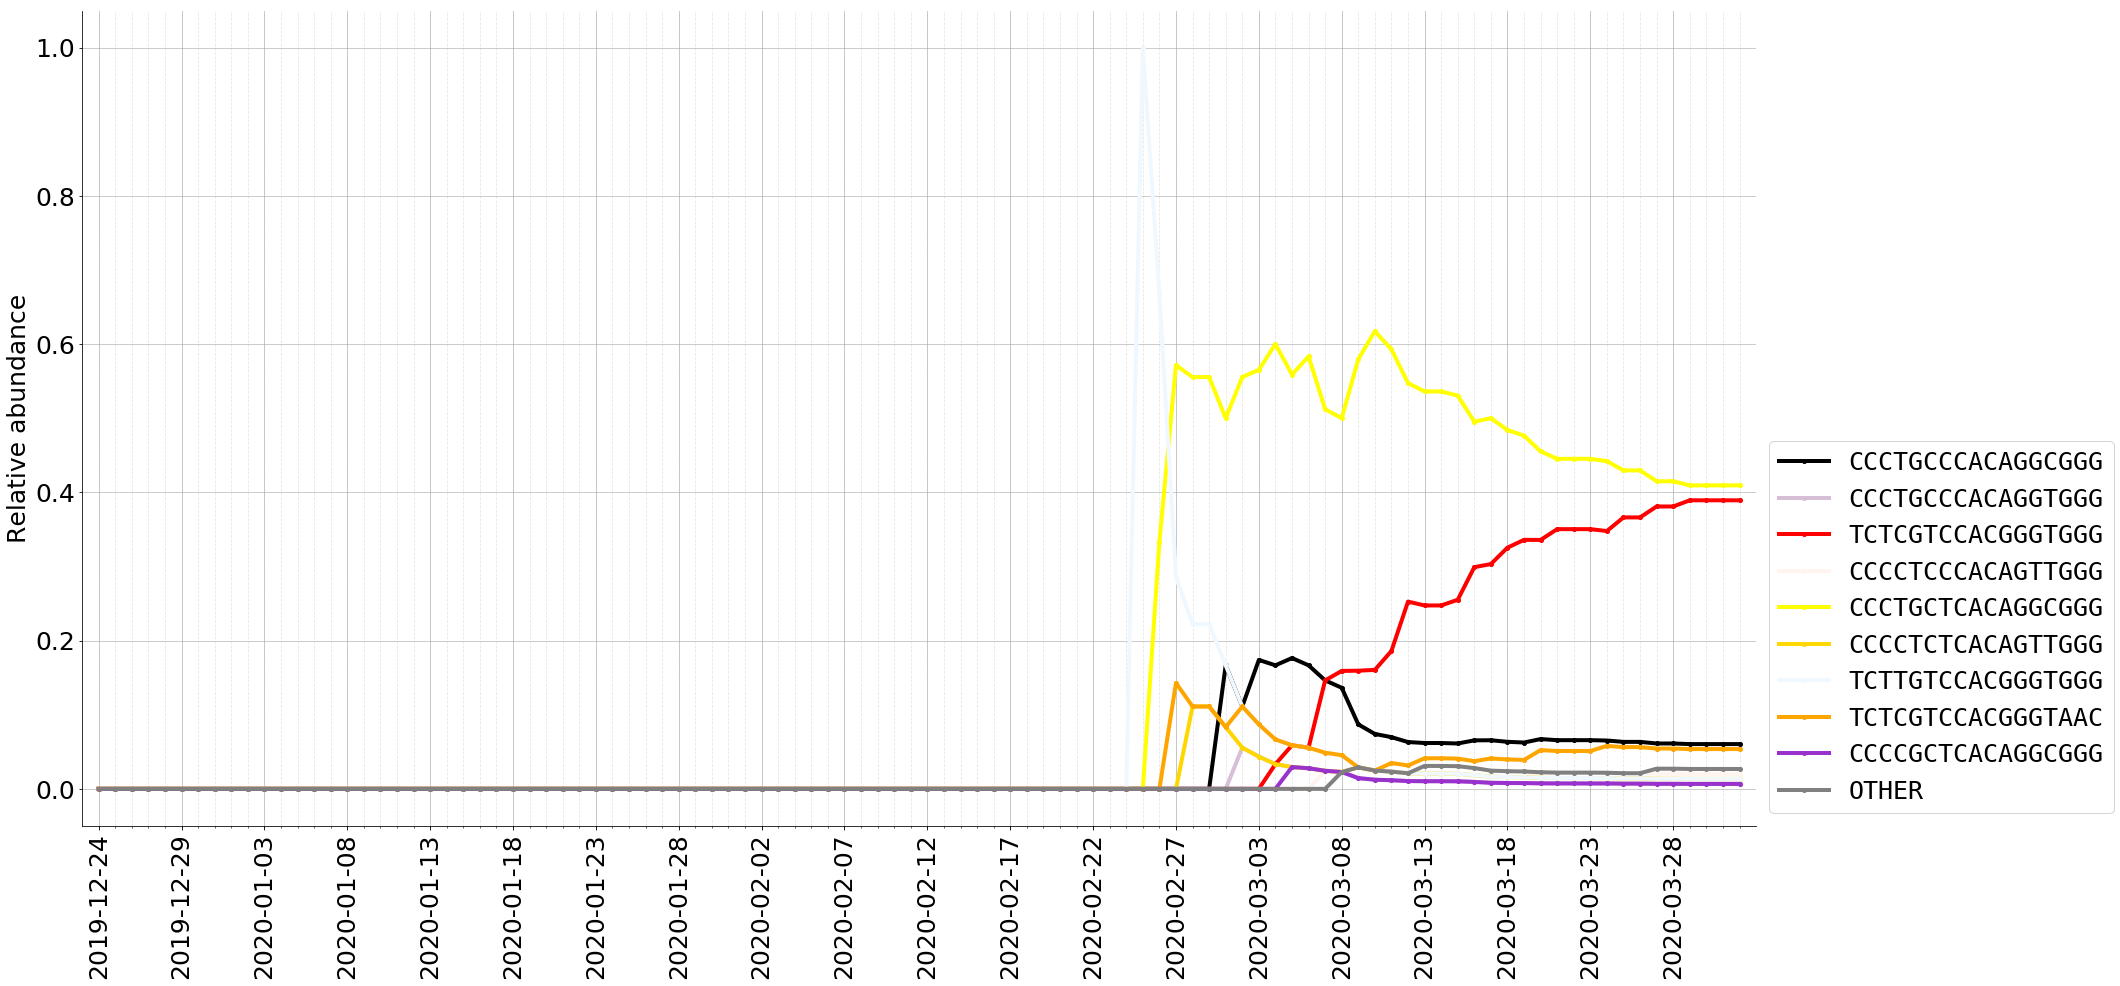

In [55]:
regional_growth_plot('Spain', count_list, date_list)

In [56]:
font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font) 
def typical_ISM_regional_growth(ISM, region, count_list, date_list):
    ISM_growth_list = []
    for i in range(len(count_list)):
        regional_dict_freq = count_list[i][region]
        if ISM in regional_dict_freq and regional_dict_freq[ISM][1] != 0:
            count = regional_dict_freq[ISM][1]
            freq = count/sum([regional_dict_freq[ISM][1] for ISM in regional_dict_freq])
        else:
            count, freq = 0, 0
        ISM_growth_list.append((count, freq))
        
    return ISM_growth_list

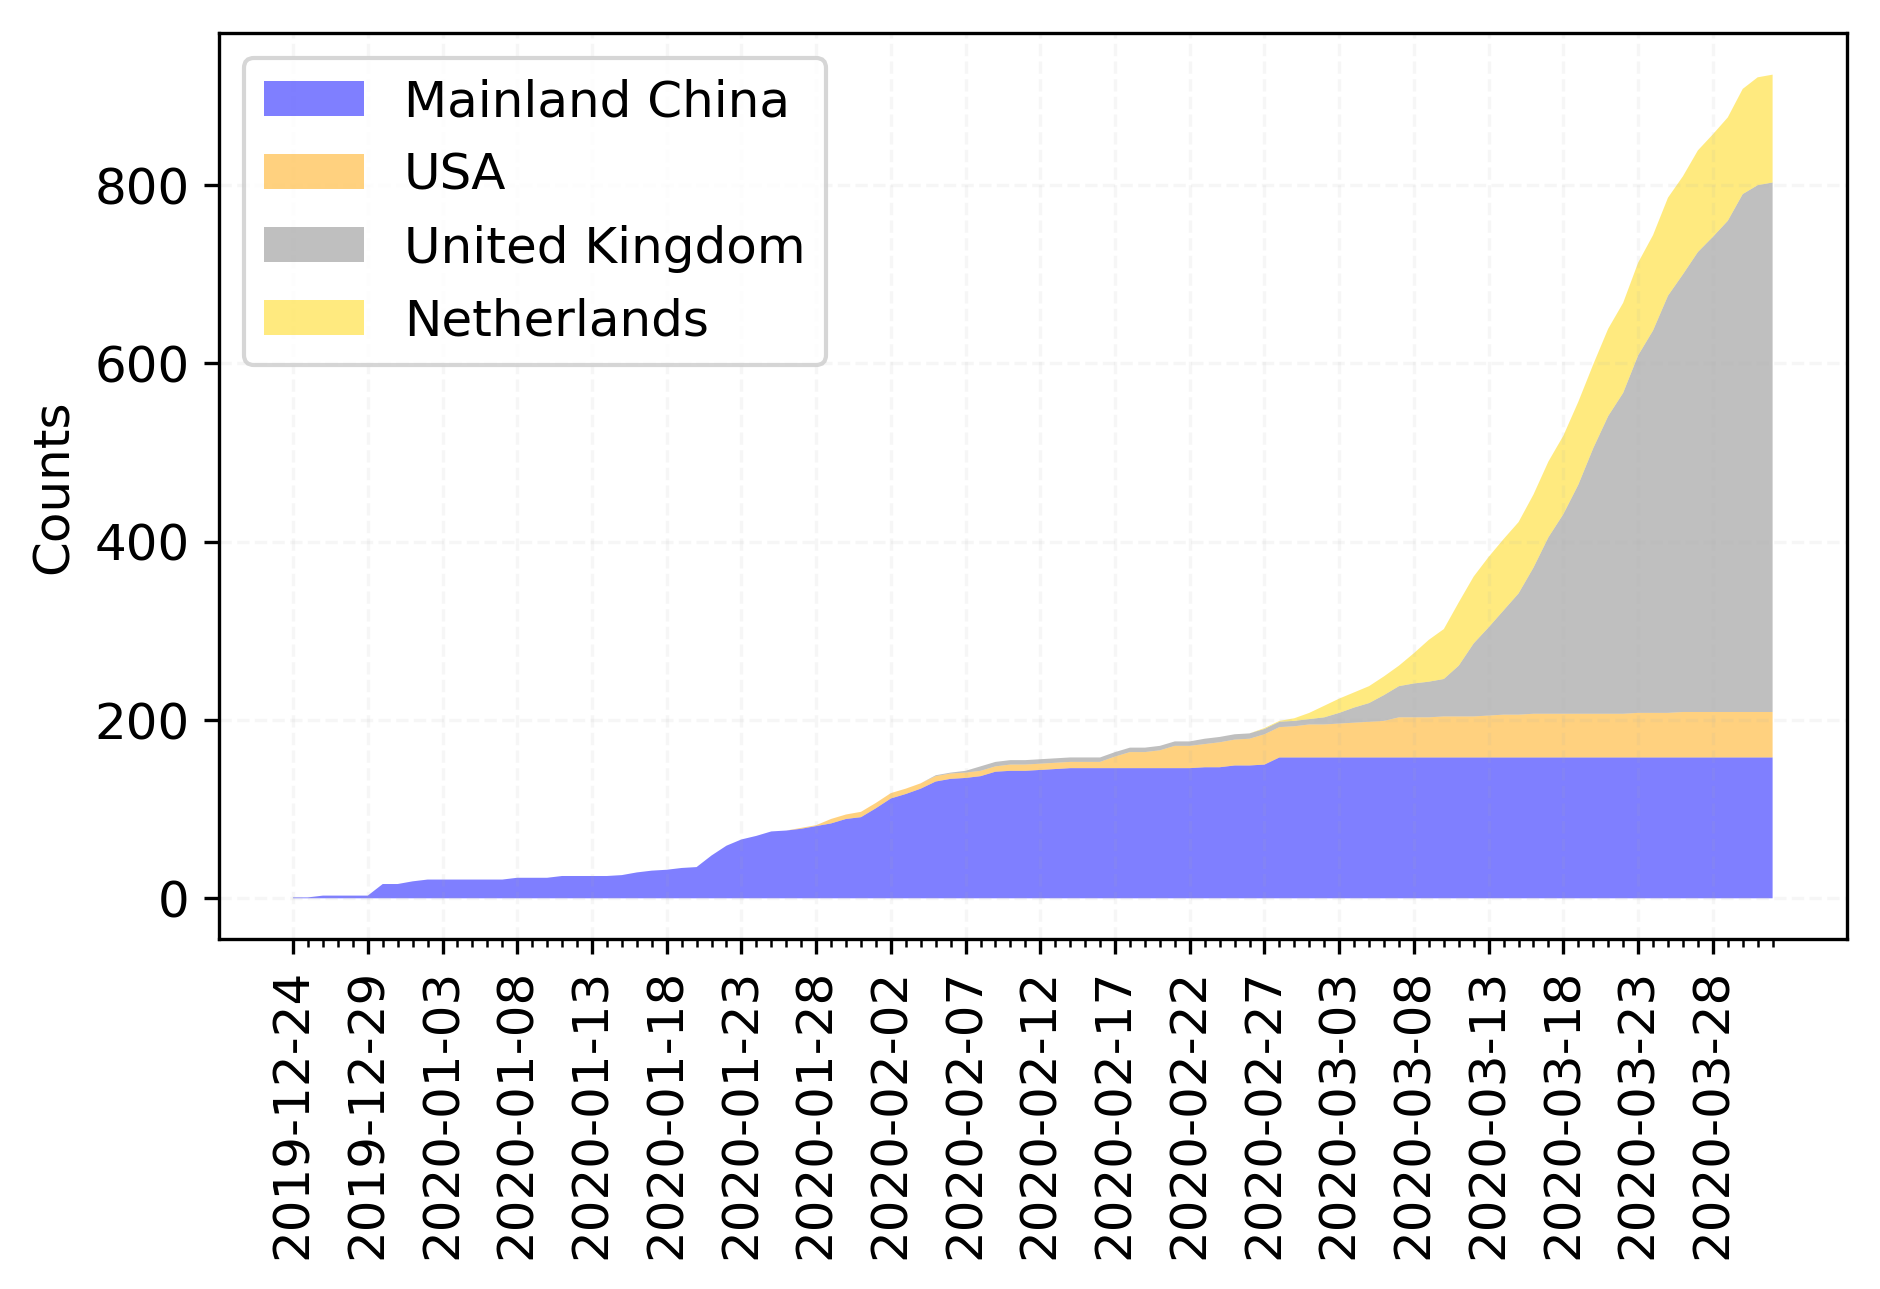

In [57]:
ISM = REFERENCE_ISM
y = []

region_list = ['Mainland China', 'USA', 'United Kingdom', 'Netherlands']
for region in region_list:
    ISM_growth_list = typical_ISM_regional_growth(ISM, region, count_list, date_list)
    y.append([item[0] for item in ISM_growth_list])

x = np.arange(len(y[0]))
y = np.row_stack(y)
y_stack = np.cumsum(y, axis=0)
fig = plt.figure(figsize=(2100/DPI, 1200/DPI), dpi=DPI)   
ax=plt.subplot(1, 1, 1)
n = 4
facecolor_list = ['blue', 'orange', 'gray', 'gold']
for i in range(4):
    if i == 0:
        ax.fill_between(x, 0, y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
    else:
        ax.fill_between(x, y_stack[i-1], y_stack[i,:], facecolor=facecolor_list[i], alpha=.5, label = region_list[i])
major_ticks = np.arange(0, len(date_list), 5)
minor_ticks = np.arange(0, len(date_list))
major_label = []

for i in major_ticks.tolist():
    major_label.append(str(date_list[i]))
#     print(major_label)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_label)
# ax.grid(which='minor', alpha=0.1, linestyle='--')
ax.grid(which='major', alpha=0.1, linestyle='--')
ax.set_ylabel('Counts')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.legend(loc='upper left')
plt.savefig('{}/9_typical_ISM_stack_plot.pdf'.format(output_folder), bbox_inches='tight', dpi=DPI)
plt.show()